This is my solution to an exercise to make a spam classifier using Apache SpamAssassin’s public datasets, which I am writing to learn about machine learning. The exercise is from 
_Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition_, by
Aurélien Géron.

Copyright (C) 2022 Chris March <https://github.com/chrismarch>

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

## Contents
- [Load and Preprocess](#Load-and-Preprocess)
- [Training](#Training)
- [Scoring](#Scoring)
- [Tuning](#Tuning)
- [Submission](#Submission)

## Load and Preprocess

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score
from sklearn.base import BaseEstimator, TransformerMixin
import re
import email
from email import policy
from io import StringIO

In [2]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    ''' MLStripper by "Olivier Le Floch" https://stackoverflow.com/a/925630 '''
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self): 
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
def email_get_body(b):
    ''' 
    email_get_body by Todor Minikov https://stackoverflow.com/a/32840516
    (this seems to be more robust, or at least easier to use without errors than email.Parser.get_body)
    '''
    body = ""
    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                break
    # not multipart - i.e. plain text, no attachments, keeping fingers crossed
    else:
        body = b.get_payload(decode=True)
    spam_key = 'is_spam'

    return body

In [4]:
spam_key = 'is_spam'

def load_email_files_to_dataframe():
    vocabulary = {}
    file_paths_to_mail_dicts = {}
    file_index = 0
    for parent_dir, subdirs, files in os.walk('.'):
        #print(parent_dir)
        #print(subdirs)
        #print('---')
        word_regex = re.compile(r"^[(]?((mp3|MP3)[sS]?|[a-zA-Z]+|[a-zA-Z]+[-\/]?[a-zA-Z]+|[a-zA-Z]+[-\/]?[a-zA-Z]+[']?[a-zA-Z]+)([)]?[!?]+|[!?]+[)]?|[.,;:)]?)$")
        html_regex = re.compile(r"(<html>|<HTML>)(.*)(<\/html>|<\/HTML>)", re.DOTALL)
        hamdir = '_ham' in parent_dir
        spamdir = 'spam' in parent_dir
        if hamdir or spamdir:
            for file in files:
                file_index += 1
                rel_file_path = os.path.join(parent_dir, file) 
                print(rel_file_path)
                with open(rel_file_path, 'r', encoding='iso-8859-1') as f:
                #with open(rel_file_path, 'rb') as f:
                    f_str = f.read()   
                    msg = email.message_from_string(f_str, policy=policy.default)
                    #msg = email.parser.BytesParser(policy=policy.default).parse(f)
                    print(str(file_index))
                    subject = msg['subject']
                    #print(subject)
                    #print(msg['header'])
                    #body = msg.get_body(preferencelist=('html', 'plain'))
                    #if not body:
                    #    continue
                    #body = body.get_content()
                    body = str(email_get_body(msg))
                    #print(body)
                    html_match = html_regex.search(body)
                    #print(html_match)
                    if html_match:
                        body = html_match.group(2)
                        #print('------------')
                        #print(body)
                        #print('------------')
                    body_strip = strip_tags(body)
                    body_strip = re.sub(r"[()\"\'-]", '', body_strip)
                    #print(body_strip)
                    mail_tokens = body_strip.split()
                    if subject:
                        mail_tokens += subject.split()
                    mail_dict = {}
                    mail_rejected_tokens = []
                    for token in mail_tokens:
                        match = word_regex.match(token)
                        if match:
                            match_group = match.group(1)
                            if match_group in mail_dict:
                                mail_dict[match_group] = mail_dict[match_group] + 1
                            else:
                                mail_dict[match_group] = 1
                        else:
                            mail_rejected_tokens.append(token)
                    file_paths_to_mail_dicts[rel_file_path] = mail_dict
                    #print(mail_tokens)                            
                    #print(mail_dict)
                    #print(mail_rejected_tokens)

                    #break
                
    # add all the words to a vocabulary
    vocab_i = 0
    for file_path in file_paths_to_mail_dicts:
        mail_dict = file_paths_to_mail_dicts[file_path]        
        for word in mail_dict:
            vocabulary[word] = vocab_i
            vocab_i += 1
            
    columns = [spam_key] + list(vocabulary.keys())
    n_columns = len(columns)
    mail_dicts = []
    # for each mail, encode
    for file_path in file_paths_to_mail_dicts:
        mail_dict = file_paths_to_mail_dicts[file_path]
        mail_dict[spam_key] = 1 if 'spam' in file_path else 0
        mail_dicts.append(mail_dict)
        
    # TODO convert to zero fill sparse from nan sparse and serialize zero fill sparse
     
    return pd.DataFrame(data=mail_dicts, columns=columns, dtype=pd.SparseDtype(np.dtype('float64'))) # has to be nan to start, fill_value=0))

In [5]:
# warning: this can take a couple/few minutes    
df = load_email_files_to_dataframe()
#df

./spam/0355.94ebf637e4bd3db8a81c8ce68ecf681d
1
./spam/0395.bb934e8b4c39d5eab38f828a26f760b4
2
./spam/0485.9021367278833179285091e5201f5854
3
./spam/0343.0630afbe4ee1ffd0db0ffb81c6de98de
4
./spam/0125.44381546181fc6c5d7ea59e917f232c5
5
./spam/0108.4506c2ef846b80b9a7beb90315b22701
6
./spam/0112.ec411d26d1f4decc16af7ef73e69a227
7
./spam/0146.6656452972931e859e640f6ac57d2962
8
./spam/0060.140f80780520fa19b360ddcb05838a67
9
./spam/0392.9e194dfff92f7d9957171b04a8d4b957
10
./spam/0441.b820c1999715c2e5ded6418d2b17723c
11
./spam/0272.97ecf97bd5f1563ac88d9eb4c8a51062
12
./spam/0278.229f1cdd03eb4e6ff86e9fd29551f577
13
./spam/0126.713b324e028cc69213e67ad3d7319f5d
14
./spam/0246.3b997087302d48ff57ab5afb3d400d5b
15
./spam/0440.16a3caff5b5788f2ae378850041252d7
16
./spam/0230.035bbcbe1235cb6fdd0a5d6d626dc5c4
17
./spam/0068.1626952077798d4f2d5eb30e48bc49b3
18
./spam/0153.eddc658b08a04641a2494ba6b6eb0a3c
19
./spam/0344.8bbe5c7c8269a039761968a1b10a936a
20
./spam/0335.9822e1787fca0741a8501bdef7e8bc79
21
.

203
./spam/0256.ad88c1a165392a509a8b0b8df6d56cbd
204
./spam/0110.20934dc65c9a88fc9c6afda9952ce2c5
205
./spam/0046.0b4fff9cd7cffe94cc4f04bbf3928c28
206
./spam/0174.3874b6ff3c86a5ebefb558138a6bfb28
207
./spam/0271.24302cf2e759401d1f9975fe4fc1def9
208
./spam/0297.9e6095368b4e8258e967798cea8fe40e
209
./spam/0372.216f90ef52558ed24402e192586a40e8
210
./spam/0300.fa3ece84a195f3d36a70f2550824071f
211
./spam/0224.486269968d3ad880a016b600dc366393
212
./spam/0033.489e59d3c7060b70e166ef7317c86807
213
./spam/0111.a163d41592b3a52747d7521341a961af
214
./spam/0192.2d3e74aaf18c1c4193067f025e757507
215
./spam/0005.1f42bb885de0ef7fc5cd09d34dc2ba54
216
./spam/0139.40f371501f8a2a3fb4ff62143c0671b9
217
./spam/0486.348918a564335556b4fdd8b82f939918
218
./spam/0173.f7902a7780f163e3896861983cd700c6
219
./spam/0277.4b6ea2e210cacce0e46064da22a05549
220
./spam/0066.93ccd9599561c5277989f03b575d6bff
221
./spam/0305.2252f3b41c7fd3a43ac132a6b3391a3b
222
./spam/0002.24b47bb3ce90708ae29d0aec1da08610
223
./spam/0150.30c4

417
./spam/0472.40695f88feb07754e40b1008aeb47bd1
418
./spam/0363.bafc8f5920a1e35acb4b06d6f6daa74c
419
./spam/0011.2a1247254a535bac29c476b86c708901
420
./spam/0085.6e7b1a983ab05445a7eaffcbb6811d3f
421
./spam/0492.f2d030fd71d7c3075626195b5c0b56f7
422
./spam/0055.8b2154bb7ec1f411495f37f519f1835d
423
./spam/0458.8c9d2363547ebaf997282910cf21e95c
424
./spam/0031.e68d1195ad2c1900a44de8631f8acd91
425
./spam/0264.2281c4eb36accd65d9c2cab379de2789
426
./spam/0170.fe4f77fa9456b48dffa9288074b2bb2a
427
./spam/0124.37afd066a74d18b7f14bea0b1fb43d4d
428
./spam/0281.7e8c08897b61b9b008238efec9ca8d15
429
./spam/0351.517e785af43ffb3f9e66ab25b3ab162c
430
./spam/0500.2e8762b67913d1b07bc8da293448d27f
431
./spam/0292.3e12964912377bd9b52d223e37812e56
432
./spam/0329.5c22249fa35fff050675e7df4433b89f
433
./spam/0450.a828f09ee44e716e6931866e4743e32a
434
./spam/0172.e524e85cab354337018e1d0d2fc21ffd
435
./spam/0214.b5ba0ff48cee07a36c6f312de7f77207
436
./spam/0179.3a4c735c7c1e494f4e7a7b9465043280
437
./spam/0215.57c4

586
./hard_ham/0018.4c0db481993d05a5a0d1ff09eb9faace
587
./hard_ham/0059.25b37bae69bc0677f978d000dd27b0ba
588
./hard_ham/0175.9da6791d7966edcb9afaab078736deb1
589
./hard_ham/0128.cec40637e142496b2603c0ee474d05e7
590
./hard_ham/0247.9afc6950aad655603a1f70edf4ba2bb7
591
./hard_ham/0093.cfcd17be3040443dac38f2ac62a5e6da
592
./hard_ham/0022.2988baa63bae8377269759384f4d73bc
593
./hard_ham/0117.fddcee5e4df575edc769d13a84cb32fe
594
./hard_ham/0157.09827ed42b5f694067929fc00393630e
595
./hard_ham/0209.2f5c7d5bc39fefaae26e95ed5d8538cb
596
./hard_ham/0242.cc7e33f6fb35ec73315649e151d66111
597
./hard_ham/0005.ebf0581994d57466ee431c7e5cf7794d
598
./hard_ham/0102.b695d3ad06a93e2582942191f2625775
599
./hard_ham/0086.04312590605a3ce851e6b050f6f2de57
600
./hard_ham/0159.bcc0a572f666161e68caf5313590bd3b
601
./hard_ham/0126.d002ec3f8a9aff31258bf03d62abdafa
602
./hard_ham/0191.47a4267102621d60e7de985f0f738f96
603
./hard_ham/0197.68819fc91d34c82433074d7bd3127dcc
604
./hard_ham/0036.87385983942b734179f43c0d6a

766
./spam_2/00665.86f20f73c5ac6205b5b79f3877638ee5
767
./spam_2/00999.f46c3f4b40ebbd0cf2752066c9372ecc
768
./spam_2/00261.e679a9947bd481d47fb1a3d83b482fd5
769
./spam_2/01247.f8e666a378e596a26a6947268a711c97
770
./spam_2/00608.bf7d77ef4f28552278f78a5aef71f0cf
771
./spam_2/00922.06a743f9aa0c1d27703342dac65a308b
772
./spam_2/00580.c3b23134b4767f5e796d0df997fede33
773
./spam_2/00204.4cf15f97b8ea08bfafab7d5091b8fbe7
774
./spam_2/00550.f7e75438e70eb4222c1a93fd190c8ce1
775
./spam_2/01022.55c9eda45ef3de55b8c27c214a1fc305
776
./spam_2/00180.751cb63992e172566b3a296d970c425d
777
./spam_2/00251.2ca1d22841d472917231911f63572dfd
778
./spam_2/00945.cd333ea4e3a619e54e63e621e56b324a
779
./spam_2/00533.4bf72df6acf3c08c213584469484b0ed
780
./spam_2/00557.01f1bd4d6e5236e78268f10a498c4aba
781
./spam_2/00411.e606c6408dbcda1a60be16896197bace
782
./spam_2/00826.01ebf3d0e89c1cec3528f9c0950b63d1
783
./spam_2/00688.9a0a9490593c7e2c9500d06bb9386819
784
./spam_2/00300.6ca4fee75f6afbd00581ceec6cf14fac
785
./spam_2

946
./spam_2/00268.a9bc047709bc6362328d3b72998956f2
947
./spam_2/00958.c624269d8005dce3d754defab3a3d691
948
./spam_2/00341.523b18faf8eb7b835457f2a0797e034f
949
./spam_2/01269.aa905c10b8358328fb77d2f900e4491f
950
./spam_2/00967.8098170f3b629df0fc0b8324445929c2
951
./spam_2/00106.09988f439b8547dc90efb1530c02329b
952
./spam_2/00755.4280e5603d66801661cbd0fe0b33eec8
953
./spam_2/00493.a80f4bf204e9111b0dd1d14bf393b754
954
./spam_2/00697.2d221d167d2814a6a6bc7a74b65bcb0e
955
./spam_2/01348.0ed90bb4a1ba1ea2309ffdbbce093753
956
./spam_2/00183.47b495fc7ebd7807affa6425de6419b3
957
./spam_2/00723.7d2f1e26ae8cbab862459e33db405be1
958
./spam_2/01079.9eb95fd88f3d9d551f8c64359470ae7e
959
./spam_2/00176.644d65f0ab0d19f706a493bd5c3dc5df
960
./spam_2/00560.dfc4142bdb51d4ac3f9a3460c9254a18
961
./spam_2/00906.bd0b0986deaf717b1f1a689fd950b97c
962
./spam_2/00112.e4952a7d270c78cd6bba9d4f6add13f2
963
./spam_2/01245.ce437204a2dfc9109003491e7812fc7f
964
./spam_2/00590.7a27fe75bf73486c1c1913f87aaddb4d
965
./spam_2

./spam_2/00670.a3175dd0b4a1e1a26822c5fee6d6837b
1154
./spam_2/00081.4c7fbdca38b8def54e276e75ec56682e
1155
./spam_2/00406.3d607f39292bdf8e71094426cc02a90d
1156
./spam_2/00552.877d8dbff829787aa8349b433a8421f0
1157
./spam_2/00289.ce923605b55bfa316d567763565e6bc9
1158
./spam_2/01342.7f89acf56fb4398340a0b07481e3193f
1159
./spam_2/00020.7d36d16fd2be07c4f6a5616590cdea07
1160
./spam_2/01218.4bb5c5746d9f19d8551437c242bfd79e
1161
./spam_2/00217.f56a722e95d0b6ea580f1b4e9e2e013a
1162
./spam_2/01127.5b6f6b674dc0dd99f225bee3d7b32e9e
1163
./spam_2/01248.27ec44a84866375481998caed54df8c0
1164
./spam_2/00150.957bb781217f762dc9999e7a90130c92
1165
./spam_2/01242.3743099b115c6a8a273d8eca34a9c738
1166
./spam_2/00123.18a793261cf7719497e17412345945d6
1167
./spam_2/00345.53eb1900901ea7c0b512d555e919b881
1168
./spam_2/01361.1b094e93a9a83d77859dcbf6637455d1
1169
./spam_2/00457.f4325a4aa30dce61bf6c442b887733dd
1170
./spam_2/00037.c7f0ce13d4cad8202f3d1a02b5cc5a1d
1171
./spam_2/00364.48aa56553a1b8c2e4b638e0f46a7fc1

1324
./spam_2/00713.8d1b1c5afc226377ec951564ad402b9c
1325
./spam_2/01212.216774fff566f005d1ef404eda7925e2
1326
./spam_2/cmds
1327
./spam_2/00264.8fae38cbbed6a43b40e83aa8496018e4
1328
./spam_2/00011.bd8c904d9f7b161a813d222230214d50
1329
./spam_2/01256.93c359e7a1edb27054778deaa633b72b
1330
./spam_2/01176.36afa20e4f8dd2246da63c3b23129305
1331
./spam_2/00336.b937e6ad1deae309e248580a6fec85d8
1332
./spam_2/00998.92da52a65a4d039a6b9c02b0d65a1bbf
1333
./spam_2/00797.de032e70954eb1194f15870abc0f01a4
1334
./spam_2/00573.f33cc9f9253eda8eceaa7ace8f1a0f50
1335
./spam_2/01015.814d23a39e0a68a8706ef9b1ce2c7791
1336
./spam_2/01103.1ad34526adee0adab5a8cda98d3f2182
1337
./spam_2/00487.edd96ac74c081d65c2106cf51daab9d7
1338
./spam_2/00972.5290463cd76d76c7dc9e2d2fb88cb8d1
1339
./spam_2/00785.262ba178488e58bbea695befb45b05e2
1340
./spam_2/00293.2503973d5b437aa173b6dd97e6f14202
1341
./spam_2/00165.3a37220d69b5b8332ee4270f0121dfe9
1342
./spam_2/01197.f88c038612948f3fa023ac83db2e2ce5
1343
./spam_2/01178.3a000ed

1513
./spam_2/00035.bd7183c238b884a153ad4888fbee9bf6
1514
./spam_2/00153.d20d157c684520f1c3aa8f270f753785
1515
./spam_2/00061.4b25d456df484b9f7e01c59983591def
1516
./spam_2/00634.c37efb809c3c54c2d9661063e7b72f5b
1517
./spam_2/00869.f81e5e18fca8debeb53ec8581e902987
1518
./spam_2/00781.8657bfadc87dd7fbcb174982f2c9d34e
1519
./spam_2/01305.2456653e0fbd780a77a3d25229109432
1520
./spam_2/00170.5e4c7668564952d8bfbf106d32fa9e5e
1521
./spam_2/00383.14f8e467cb84b977c33f422d7d1691e6
1522
./spam_2/01287.45b0eefc02506c5c82e5ab4ffe2fc625
1523
./spam_2/00483.e583ffb0efd3958cdef2e9f3b043ef0d
1524
./spam_2/00415.4af357c0282481dba8f1765f0bf09c09
1525
./spam_2/00062.6a56c37b8db0cbfb57a99b32ad60b4d2
1526
./spam_2/00447.32e588c3a1d8888d737f360f825713b8
1527
./spam_2/01331.e35989787f99e9f234da42636eb43f22
1528
./spam_2/01314.12c8b5b91bc690f0f0d6fad595150ac6
1529
./spam_2/00629.5feadfcb7530c08a54c98178600b2f70
1530
./spam_2/01292.3cfdacd938c6a4a7544581399e28e81c
1531
./spam_2/00683.41038a20d4763e8042a811a036

1668
./spam_2/01378.73df5252cb71f89c885ad49b6ae5fa82
1669
./spam_2/01288.ffe370e3a92a1861533330da51edcb49
1670
./spam_2/01229.bec63972cefbe62bb371ad659cd8563a
1671
./spam_2/01104.ec267abf01fe81c42dc90dfd16c930bc
1672
./spam_2/00313.4363902393c0037670bc9483d19dc551
1673
./spam_2/00635.f144125beb9621e7a73d1a2eadce7e06
1674
./spam_2/00405.39099b2d9fc7da44f0bd7c5d68c06ca6
1675
./spam_2/01131.c9bb07673bf9f048916cd2b9b1813724
1676
./spam_2/00133.7dbf2e71621f92eada31cc655ff12fd3
1677
./spam_2/00220.b599bb1ef610ba40d9becc965c0c0da3
1678
./spam_2/00714.cd13d8db12cc1f661d6b2eb6fcbb5156
1679
./spam_2/00752.c0892cd4ffff618e689dec28f2f4695e
1680
./spam_2/00901.95250e8c5c190d1b0320b9e6fe0f5a82
1681
./spam_2/01155.e8634e51df914973d548076958ed90b2
1682
./spam_2/01057.b3913dec24f1b61e2ff45e30cdbb8fcd
1683
./spam_2/00799.23a850930770d537479280490fa6a412
1684
./spam_2/00221.775c9348b935d966a9afec954f1e9c27
1685
./spam_2/00904.8f93ecb6172ee1feba7b4248c48b9ef5
1686
./spam_2/00501.32679091b0520132ad888ef3b1

1871
./spam_2/00473.594d47d74b993e949b2b472af3430aed
1872
./spam_2/00842.bd26298437dec2f1d09fd757afbcb13f
1873
./spam_2/00455.8ccdcb205b6f8c3958bb3b2d39edca46
1874
./spam_2/00301.3b6fa92db458408d9468360fc034d280
1875
./spam_2/00939.8d335bc76836e51b449de9f6b38aa0f8
1876
./spam_2/00043.9331daf0bd865aa657cb02cbcd06173b
1877
./spam_2/00875.535ae4621326594a8c9edbc33c06b408
1878
./spam_2/01384.e23f94030a4393f0825eacd9de99eb31
1879
./spam_2/00050.bdb8b228ff67fd4a61f8b0c8e81240c9
1880
./spam_2/00682.0160e510bf19faa60f78d415d4b9a3ee
1881
./spam_2/00378.958f8c0f9d486c1e18f835ab65664b4d
1882
./spam_2/00990.e0282a91be0479aeadc4ee580bf21ded
1883
./spam_2/01106.37f316c0f77e739cb5fe0e37aaea2046
1884
./spam_2/00607.b5726a2ac74956ab9af0901379cdca5c
1885
./spam_2/01060.d72413ea3af9e1c5530a3570e0bb517e
1886
./spam_2/01359.deafa1d42658c6624c6809a446b7f369
1887
./spam_2/00168.a9dd80bb0934b67fd00b4f0a99966369
1888
./spam_2/00969.636d340655d05418edc2d1cd2ca05b72
1889
./spam_2/00734.0c1975b8c2b17fd6c665827706

2072
./spam_2/01347.e2cd456cd2d58601fec5a5b6323463e1
2073
./spam_2/01323.043a9a503f711ebb76897fa1c352d7cd
2074
./spam_2/01030.2f9d18088877f028b4ebcb3961e76354
2075
./spam_2/00082.92b519133440f8e9e972978e7b82e25e
2076
./spam_2/00737.af5f503fe444ae773bfeb4652d122349
2077
./spam_2/00436.9fc1d953c6a282c5b66e4ed1cf1b866f
2078
./spam_2/00777.284d3dc66b4f1bdedb5a5eba41d18d14
2079
./spam_2/00003.590eff932f8704d8b0fcbe69d023b54d
2080
./spam_2/00975.5e2e7c9d8b2c04929ff41e010163e5e8
2081
./spam_2/00431.c6a126091c0bcbc44e58e238ca4d02c6
2082
./spam_2/00850.f57827e297da1c01fe028cfc01e20361
2083
./spam_2/00499.257302b8f6056eb85e0daa37bfcd2c68
2084
./spam_2/00373.a2e4ba80486fdff8084086d447e01d17
2085
./spam_2/00296.85aa16f800e0aaf8755cdf23d7e035ff
2086
./spam_2/00618.3407355607b3c336ddee20b1435abf01
2087
./spam_2/00891.730d12d96dcfa7812a51d12d9a3b6a1c
2088
./spam_2/00817.446795af3e79a13e7c3aa784573bcaa0
2089
./spam_2/00599.d6d6a2edd58fa7dd6b18787e9867984b
2090
./spam_2/01233.010677fced50f4aecb67fba707

2283
./spam_2 2/00273.c832f32bbe447980ad0095b772343563
2284
./spam_2 2/00740.ce4777381c2bc6bee30bef6bd274233f
2285
./spam_2 2/00759.23e678ecd735ad618ad151d311c81070
2286
./spam_2 2/01222.86831c8b346812d6526d6ddc7d3eb185
2287
./spam_2 2/01042.7b53680639a0b4ec9e333ce3046b6af4
2288
./spam_2 2/00525.979fd0c4cc9c0f2495c564c5501a46ed
2289
./spam_2 2/00839.35a9240a97695fd8ef777c6a1ccd3b18
2290
./spam_2 2/01167.2ac57a0189fa2b8713202b84e587b707
2291
./spam_2 2/01141.9771b6eb9a19ad26816825c9d190831d
2292
./spam_2 2/00498.7f293b818e2e46d3a8bad44eda672947
2293
./spam_2 2/00985.13d06699ecd95078655fa3d24e3b6d03
2294
./spam_2 2/00210.2942a339c3792a1010d024e6d6ba032e
2295
./spam_2 2/01345.436954c32bbf82773e33853ac26ef881
2296
./spam_2 2/01143.b92dc050e0b748b5e7c9f1cf1b469306
2297
./spam_2 2/01199.5a219c9b3e55a0136d8039fd74675570
2298
./spam_2 2/00519.f189e2f1541968e48de6ebd9db23b35d
2299
./spam_2 2/01225.a07c90bc24b619d5e8b786675dc2d118
2300
./spam_2 2/00645.dd7d8ec1eb687c5966c516b720fcc3d5
2301
./spa

./spam_2 2/00236.a46588c69d43e80c618038b95eff2893
2489
./spam_2 2/01004.f3ce5cdf52dbe7ed22354f1ab95376d6
2490
./spam_2 2/00504.0a250a54cc14771c55105d9cfdf39151
2491
./spam_2 2/00746.f0fce8c4c17e53a0fe837a8c6cfe03c6
2492
./spam_2 2/00492.3052cad36d423e60195ce706c7bc0e6f
2493
./spam_2 2/00451.bbff6de62f0340d64a044870dbedafba
2494
./spam_2 2/00860.f1651a6a5f33bafe34e23afeacf85eb1
2495
./spam_2 2/01180.e8f2a113a0c6e413929162543819aa11
2496
./spam_2 2/00733.095d8b33e938efa091f1771c622986c9
2497
./spam_2 2/00135.9996d6845094dcec94b55eb1a828c7c4
2498
./spam_2 2/00586.6ffe1b192d01dc82c33e866ddabd2a79
2499
./spam_2 2/01353.369f79f8f31f3b18bdb5d1006207b52e
2500
./spam_2 2/00870.ecbb85c7b91446c971762de0b9735b4d
2501
./spam_2 2/01285.4bc4cabd8d963b1e33bb56aaaf191328
2502
./spam_2 2/00007.acefeee792b5298f8fee175f9f65c453
2503
./spam_2 2/00274.192bd3848a65302344dff2d7c0d3f08a
2504
./spam_2 2/01092.7a97a1db89c8b78df9cb59aa0d0b1fb4
2505
./spam_2 2/00490.09cc8eacfd07338802c3ea0e7f07fe26
2506
./spam_2 2

2683
./spam_2 2/01138.21608a055666b8a00c1945bb2a740190
2684
./spam_2 2/00426.c743511223777504c01a35f90914b230
2685
./spam_2 2/01062.c35ba7728139dda6e85342e9e8cb2eaa
2686
./spam_2 2/01076.7f524e1d3f1523e22d754ce5d4a27ae6
2687
./spam_2 2/01098.4ea844b47fbe9b09a9cb7bbdb96ed3dc
2688
./spam_2 2/00811.1a510ce29a20ec57048d6b29d0056d57
2689
./spam_2 2/00539.6e6f7b032b644f9b1355f46d20944350
2690
./spam_2 2/01316.80287bffff0da77d7b22a538aefdbd01
2691
./spam_2 2/01191.3a3ed1eb843a56504a4b40a25a63f97f
2692
./spam_2 2/01100.3db9aa127f49e790a5f2765a8f9724f2
2693
./spam_2 2/00561.c1919574614e88fbabbfb266153560f2
2694
./spam_2 2/00015.206d5a5d1d34272ae32fc286788fdf55
2695
./spam_2 2/01094.91779ec04e5e6b27e84297c28fc7369f
2696
./spam_2 2/00633.60e6bd78b497893f8b33650bd1c2c0b0
2697
./spam_2 2/00076.7d4561ac3b877bbd9fd64d1cb433cb54
2698
./spam_2 2/00772.deb64399accba9b54b5f10ae57c7bbb5
2699
./spam_2 2/00482.f839ea522f1ee459661a6b2fbd71e823
2700
./spam_2 2/00078.f318607d8f4699d51f456fea10838c5a
2701
./spa

2893
./spam_2 2/00659.668ba8daca71e86de0ee5e412b177015
2894
./spam_2 2/00971.6d8acd89e1b2e699acc6a3443c6d2d6d
2895
./spam_2 2/00716.125a0992aa9fd11f5e7a8fa5a93a048e
2896
./spam_2 2/00741.00c61b5577b6fa232434c2ae62d52394
2897
./spam_2 2/00281.d5147756d766fba6dbc649f786e38bc2
2898
./spam_2 2/01193.7c4b9a0e900fdb7cafb86c1131f79a48
2899
./spam_2 2/00377.8568faed5f5f8cd3fb0956786da98a1a
2900
./spam_2 2/00505.d4fa302630b3e58461b644f7b3e11d82
2901
./spam_2 2/00260.49cb520f5d726da6f1ec32d0e4d2e38f
2902
./spam_2 2/01283.e120df13e515b3cd7f0a14e21c9bf158
2903
./spam_2 2/01021.8e30e6b936bfbdc8528c50d4a3ca378c
2904
./spam_2 2/01065.9ecef01b01ca912fa35453196b4dae4c
2905
./spam_2 2/01376.73e738e4cd8121ce3dfb42d190b193c9
2906
./spam_2 2/00218.e921fa1953a3abd17be5099b06444522
2907
./spam_2 2/00791.68d57323ce71a6f706248a709363e9a8
2908
./spam_2 2/01095.520dcad6e0ebb4d30222292f51ee76ab
2909
./spam_2 2/01330.dafb0dd3006f86f73f42b4e24266277c
2910
./spam_2 2/00071.11f438a86f442fd5a0772eb3908c12b4
2911
./spa

./spam_2 2/00892.98aff9f92339cedef0ce0b9bade2765f
3045
./spam_2 2/01130.f286229e3c2eeb5c682204de85d903c0
3046
./spam_2 2/00810.bceaa748f9cee012c466212d8a608acf
3047
./spam_2 2/00257.96e9617c812f9d9a8ec77c9008e1e960
3048
./spam_2 2/00067.bf32243a9444bba9cba8582fef3d949e
3049
./spam_2 2/01114.1499922e828350a4f6076ef4a0de3ec5
3050
./spam_2 2/01120.853b87a34ab28efd22d9851702b2f9c5
3051
./spam_2 2/00983.753f8ed9cf897cce13c3d5358f2d77d4
3052
./spam_2 2/00060.639a625d0a724d7411e1d5e2e7cb2bc3
3053
./spam_2 2/01263.4e9dc99aae6eafdf9233e60b6d3225f9
3054
./spam_2 2/00526.9a55d84e77b13b309a15ccce04901f94
3055
./spam_2 2/00005.ed0aba4d386c5e62bc737cf3f0ed9589
3056
./spam_2 2/00814.6b37fa2239e8c84e2237c4b156e16d81
3057
./spam_2 2/01383.a4e83a74006864de20f76d0193908a56
3058
./spam_2 2/01140.c37701901dbb63bc34e8db544f431557
3059
./spam_2 2/00986.d5cdaddf809832f37d3d0ecd2ea781ff
3060
./spam_2 2/01271.c74d2888efc2f1897ee890001abf05e7
3061
./spam_2 2/00088.34ca147ca21f4b3e966fe58bc054aaf6
3062
./spam_2 2

3260
./spam_2 2/00796.1f29c490fd2bd8581d19e3e193978a3d
3261
./spam_2 2/01159.ff9629cf51f03cb35075a51950e73a4d
3262
./spam_2 2/01074.d22922a762aea4d5a5aa2615e144585a
3263
./spam_2 2/00128.102ef1e6b36b8307faecd1f2d04cdbde
3264
./spam_2 2/00800.770c5025e1f05a52d805d04cbc74252f
3265
./spam_2 2/00653.dcb006e0c0aaa7aa3e5bd7cb3d444f23
3266
./spam_2 2/01334.24b7f4702e0da7e9d7a5f4d284adfc96
3267
./spam_2 2/00735.474fd4bc103225c72fd82d88bba48e56
3268
./spam_2 2/00473.594d47d74b993e949b2b472af3430aed
3269
./spam_2 2/00842.bd26298437dec2f1d09fd757afbcb13f
3270
./spam_2 2/00455.8ccdcb205b6f8c3958bb3b2d39edca46
3271
./spam_2 2/00301.3b6fa92db458408d9468360fc034d280
3272
./spam_2 2/00939.8d335bc76836e51b449de9f6b38aa0f8
3273
./spam_2 2/00043.9331daf0bd865aa657cb02cbcd06173b
3274
./spam_2 2/00875.535ae4621326594a8c9edbc33c06b408
3275
./spam_2 2/01384.e23f94030a4393f0825eacd9de99eb31
3276
./spam_2 2/00050.bdb8b228ff67fd4a61f8b0c8e81240c9
3277
./spam_2 2/00682.0160e510bf19faa60f78d415d4b9a3ee
3278
./spa

3476
./spam_2 2/00003.590eff932f8704d8b0fcbe69d023b54d
3477
./spam_2 2/00975.5e2e7c9d8b2c04929ff41e010163e5e8
3478
./spam_2 2/00431.c6a126091c0bcbc44e58e238ca4d02c6
3479
./spam_2 2/00850.f57827e297da1c01fe028cfc01e20361
3480
./spam_2 2/00499.257302b8f6056eb85e0daa37bfcd2c68
3481
./spam_2 2/00373.a2e4ba80486fdff8084086d447e01d17
3482
./spam_2 2/00296.85aa16f800e0aaf8755cdf23d7e035ff
3483
./spam_2 2/00618.3407355607b3c336ddee20b1435abf01
3484
./spam_2 2/00891.730d12d96dcfa7812a51d12d9a3b6a1c
3485
./spam_2 2/00817.446795af3e79a13e7c3aa784573bcaa0
3486
./spam_2 2/00599.d6d6a2edd58fa7dd6b18787e9867984b
3487
./spam_2 2/01233.010677fced50f4aecb67fba70701bcf5
3488
./spam_2 2/01102.823fb9065f0dadccb76633810487a19c
3489
./spam_2 2/00935.64a85d481bc17b3b61da7861f9a4d0a3
3490
./spam_2 2/00092.ba043c4ba04c2d06714e43caa42cc078
3491
./spam_2 2/00471.df77fa930951f79466c195052ff56816
3492
./spam_2 2/01200.6d388843b6ffefafaf7b3093ca28a740
3493
./spam_2 2/01025.936514974d8ee8794cf80e3effea92c7
3494
./spa

3653
./easy_ham/0621.feb00fa392669a54bc5602f927fbae12
3654
./easy_ham/0532.0a4c127cb659ebad1f4366cf3eb93b83
3655
./easy_ham/1814.95d3ab2beeba9b96666d25c09de2143f
3656
./easy_ham/0291.b37f92cfbb14d2f6a43c705ef7381702
3657
./easy_ham/1138.f044795ad01dc8592e1571539f800719
3658
./easy_ham/1103.e4d34070786a4d46da1061628bef2b57
3659
./easy_ham/0383.62511f9f1c1817dc6df14eb4912163c2
3660
./easy_ham/1245.2e33632f51f5c7cb7a0620decd151eab
3661
./easy_ham/2510.4de2705ed127d2de3f3b5cd1b8043ba6
3662
./easy_ham/0033.e3fd617544226dc06abf36c95a9a2d11
3663
./easy_ham/2077.eba992ea7cedb65c1fddbf9ea01484f3
3664
./easy_ham/0899.1f868150b365a5f407f46f908fe879e1
3665
./easy_ham/1357.c307e11b21bba14e568cd03731de0119
3666
./easy_ham/2445.631e9fa95e78d7f56fce09a4e6da56fd
3667
./easy_ham/2005.f95c773a32ba576c1da3324820a33f74
3668
./easy_ham/1046.06207e3824a4024e41215defe29e1ddf
3669
./easy_ham/0193.74f52046990258e5eb60e561dcd8c2fd
3670
./easy_ham/2427.2e44be16705ea1d39a01befda3915eb7
3671
./easy_ham/1209.8d537f0

3836
./easy_ham/0921.5a4eee7f38a1451abb6054901280b699
3837
./easy_ham/0220.1cca495dc30f98fc43adb00683029dbf
3838
./easy_ham/1886.bfb82bb59d7af53e18c36ad736c7d99b
3839
./easy_ham/0062.b675bdb7b9e2321dfe97e48037fe7782
3840
./easy_ham/0516.3b4b9b147de3e2b7ee1ca08792a9d948
3841
./easy_ham/0689.0b105c87d5d0ac5638013457882d917b
3842
./easy_ham/0693.34e853f55e9434e84268d25d2f0a6f91
3843
./easy_ham/2337.f9b3f7fca5d81b0c44d65c8963974f64
3844
./easy_ham/2056.0fd1b3fc03eea7295b13b1a8ba785ce5
3845
./easy_ham/1940.a50f7af9a2b291721d17dff887604026
3846
./easy_ham/0953.31be50aa4dfd43d0f597afe9968977b7
3847
./easy_ham/0065.b72ddcc517cc317f3fc1e79c3feeca15
3848
./easy_ham/1941.a36b85a4d1e7b2898662ebb36e7c1072
3849
./easy_ham/0744.8148cbab42e9b5a4f31f22017b3eccc4
3850
./easy_ham/2364.3e4ea188baa5301f26758bee4aeeae57
3851
./easy_ham/1298.d2696bf43cfe971dae857c2d0946ad20
3852
./easy_ham/1051.cf81a19208b703f18497a0d6fedb1f13
3853
./easy_ham/1345.df3d6d8a5d9e6bba6484fbef2dae9102
3854
./easy_ham/2402.f17c22d

4036
./easy_ham/1812.f25ce16131a4a1e9b4eb4e04f748509a
4037
./easy_ham/1472.817651cadec68cf13d9b23d336825269
4038
./easy_ham/2006.65d9202fe457e8c8eb1510926632d148
4039
./easy_ham/2358.5fbef21d157da3cf529ad0b1773fcbaf
4040
./easy_ham/1408.c202263092b223a607078977ed7aa6c3
4041
./easy_ham/0988.0743b9293ec2636dbc6065acd9b646fb
4042
./easy_ham/0732.63667434e8712ed16361596f40c468ed
4043
./easy_ham/1390.6e72b8ce6b837d6072790479e742fb4a
4044
./easy_ham/1978.9e384f828b5c1d538c7758ffda11e3a1
4045
./easy_ham/1436.b6274330d7d8fd92eb9cfc2f999555cb
4046
./easy_ham/1493.0e19ac93ca8fe935323151417bc2e959
4047
./easy_ham/0189.01e4dc6ee1379e5ee100b4c33c9c3afd
4048
./easy_ham/0923.62f8eb57510330d6658ea55e5d7277df
4049
./easy_ham/0184.9006c74135af56c874879f0d45c1a689
4050
./easy_ham/0311.de3984f9da9dba841ba515681fa065a6
4051
./easy_ham/2044.44bf59ea8589daeadc7af5f5c4d7827a
4052
./easy_ham/2282.0d102fad2c79a83bef590c669666f298
4053
./easy_ham/1186.fcd93eee19319006fece61d0d3a0bc13
4054
./easy_ham/0241.f1989a8

4237
./easy_ham/1302.cf60285f99cfeeca015a2c1a02cfba61
4238
./easy_ham/1772.d4ebf95243e3b22d80ea63a1f2be06cc
4239
./easy_ham/2091.1a1d629678aa1ab8953772a2cd006183
4240
./easy_ham/1386.bf3a96041aeac7950ee23a553e1fd186
4241
./easy_ham/1342.6770473802a7dc7ab14a212f95573c15
4242
./easy_ham/1089.8c0c02d20cf78372808b29860b4e406a
4243
./easy_ham/1049.dd8e9af1e92bc41d998cc4159e5588d5
4244
./easy_ham/2487.68761726d5f3f00dca1dded48e089e68
4245
./easy_ham/2381.b2da2e96c499fbf2c4cc0ff9491cf337
4246
./easy_ham/0594.30616a68b04f216bcea0ad52073c0df4
4247
./easy_ham/1266.52a2bf88987e97b6f4d5a743e353d50a
4248
./easy_ham/1267.3641b74038e9f1bc91bbf8318572ffd1
4249
./easy_ham/1533.cdca6023330291efad8880619bc3c68e
4250
./easy_ham/1319.58000a90a0ce3ea98762d31df028af02
4251
./easy_ham/1531.fe3474ea8fb4195ac74e644161f47c76
4252
./easy_ham/0557.4a673d945072f8ec9ef08a4366f25bc1
4253
./easy_ham/0356.b70fca5029fcd82a09ec6b960f4920af
4254
./easy_ham/2326.73396f0421612c54d1c9727ed953582e
4255
./easy_ham/0132.bcd2322

4440
./easy_ham/1385.be576b43bd3da84b5752402ef0acf1d4
4441
./easy_ham/1661.ea88a58a5adbb42b5f456544688849ad
4442
./easy_ham/1359.a4f9b2b4bbae9e1d2ab34ba5fec9eb35
4443
./easy_ham/1170.c4b2c469732c9fb5366078ecfc5c5823
4444
./easy_ham/1262.6826573e4fe12221d02721aa9817da24
4445
./easy_ham/0709.fdcec3f216a4caf2a548940569372d10
4446
./easy_ham/1764.1393ea887720c777d1429b07fce98ab4
4447
./easy_ham/1167.9006901f5178e82edffb4f9167f7c586
4448
./easy_ham/1798.5914721a121b85cfdc0e39bf4b4e8970
4449
./easy_ham/1274.a44315970d569047925df38e03c62d4e
4450
./easy_ham/1756.b13797de35037c4f26356e89ba3f9fb1
4451
./easy_ham/1361.3851fdfcb5a5f99e2e47fd8150641280
4452
./easy_ham/2274.a2455971f8acebeacaff3d948621f9fd
4453
./easy_ham/1653.19b45239333519205611b669843294cd
4454
./easy_ham/2528.8b6dd74e9b8d04f5f1338bcec51b0b11
4455
./easy_ham/2052.26af2a75e1e49e4ce02a01912ca86601
4456
./easy_ham/1613.19c5758c67f8ba03cd7412c56c979390
4457
./easy_ham/1023.909ebf9dc802a8f97b0d722ad443dd42
4458
./easy_ham/1121.51f7e5e

4655
./easy_ham/0280.6dca279b3e6aa252197d8439841032b4
4656
./easy_ham/1174.92cf3d9c75add5883005eae0732c5a85
4657
./easy_ham/1592.e024e5de503dcf463bad5cd5c8c64210
4658
./easy_ham/2031.81bbf025232d0d1f70571c9169091565
4659
./easy_ham/2137.0f7a7520bac29f7b0f65a8f44350aaa1
4660
./easy_ham/0360.f47b9aa1071c95031d17821c25d3de78
4661
./easy_ham/2058.223e1c8e29bf95617ce84cebf836351e
4662
./easy_ham/1318.d5b97eb2ad5aaa5b11c2c1ea00c34194
4663
./easy_ham/1841.780eecf7f0db1db00bd0a6248de51260
4664
./easy_ham/1625.08690a3d25fcaacc8929c31657f85c8f
4665
./easy_ham/2351.d418f84c3f3e02133b0ce67a243ecff4
4666
./easy_ham/0998.9b9e34483f3588514be24dd97961764b
4667
./easy_ham/2277.481836b537d072e0a7f4374797dae6b6
4668
./easy_ham/0495.5c4fb5aab57f610e00c4d3b951216f16
4669
./easy_ham/0540.e0eb7ff6a98c054571e07addde3cc4de
4670
./easy_ham/2162.98dd059bc733c48b26e52ba59cdbe574
4671
./easy_ham/1677.0a982c2dd05563772b84243adbe8a720
4672
./easy_ham/0897.c0fe033806bfaf60f935e01aec04eec6
4673
./easy_ham/2317.16836d0

4856
./easy_ham/0307.d7beae100d2ee2557b7fed18b6050a49
4857
./easy_ham/1909.97cbba56dde3e037c13ff2911be560fd
4858
./easy_ham/0092.a1560d2416687b2db8204c2fa69163f2
4859
./easy_ham/0410.a5e658e20b48409116fd339f5a8473f7
4860
./easy_ham/0761.e0096025fc83e5704a05d505cf96cca5
4861
./easy_ham/0972.58234e68337a7a333ca40560900f82d9
4862
./easy_ham/0760.15302b8ee38651c2da6e4df6a7358c98
4863
./easy_ham/0888.a8cf27198dd5b8612b47fe3f8f19266f
4864
./easy_ham/0535.e5e6e90ce659ed0f9d4063350a836201
4865
./easy_ham/2305.52534ae9c6df39a69aec3fe839d8d4a0
4866
./easy_ham/1646.b241667d03a7ff89619c30cbe2f8dab2
4867
./easy_ham/2235.2c1ba5a3c31ceaf711a04c69a5ee5647
4868
./easy_ham/0012.d354b2d2f24d1036caf1374dd94f4c94
4869
./easy_ham/2405.6e9650560fd0949f45dfa090e2588fb0
4870
./easy_ham/2328.da7bcb9a3752151e475ed0b137f3e863
4871
./easy_ham/1482.75a9c57c2bd53175e33ee6ed037400fd
4872
./easy_ham/1595.fa533692bb0d635d6d1219663ee0f82c
4873
./easy_ham/0781.cbbfe78e21c332b56c7e3630aeaa9585
4874
./easy_ham/1380.c3103ee

5057
./easy_ham/0652.5ed46908836bacba742b337197ce3499
5058
./easy_ham/0254.d40c629a02c7361e674d0d96ca130fe0
5059
./easy_ham/0789.3dfa0525c97f1a875fc55edcbc71422c
5060
./easy_ham/1734.8ce5e8ddf445f56cb18afa778b07df0b
5061
./easy_ham/2298.4cc2b00ffe4157b63358fadc3dfa689f
5062
./easy_ham/1733.95212a5ae78a283bf7282d310d7731d7
5063
./easy_ham/0544.6498586c31db44aac98902ffc6cee696
5064
./easy_ham/1222.c6701f56a4fe6d8e66e652ee35a6dc75
5065
./easy_ham/1964.bfbedcb42affb489fab7fd9f85c1522f
5066
./easy_ham/1891.4bd1b844e2c796506ae9f3181c14cfcf
5067
./easy_ham/0017.d81093a2182fc9135df6d9158a8ebfd6
5068
./easy_ham/0769.3925a280a492a9354ad0ab9e338412cf
5069
./easy_ham/2151.a6512282aa9e19567fed4acac9b7273a
5070
./easy_ham/0183.fea0e7b48e16103e73462d5ee52b0d18
5071
./easy_ham/1977.28fbce6e72a12724199a85f34bc6e238
5072
./easy_ham/0082.7f7858a1a7360410ed120899504c3a25
5073
./easy_ham/0112.b6c2ea75f9f7efcd3d0e4c43a751479c
5074
./easy_ham/1565.f6d00c2ee66b5687a153affd23870524
5075
./easy_ham/0690.d6ab63f

5260
./easy_ham/1039.28e0f6b0f1e09bbcebc01183bd3557c4
5261
./easy_ham/2243.513e9282cb2d858393bc959ff81100e6
5262
./easy_ham/2283.d3fcca4cc0478a5b3cc83334479e703a
5263
./easy_ham/0409.7fdf4f0f8aad0b0ad4654b10afae9225
5264
./easy_ham/1847.add31f8a35fa0fd63e70eacd58c82a44
5265
./easy_ham/2180.88d59369ba5887b4261ed9ab2d7df389
5266
./easy_ham/1118.41f75976258428a527855201ced28007
5267
./easy_ham/2340.40c9d3c3940d1c4a9ec570ce144798d2
5268
./easy_ham/0509.905ad1e9516c02082472a79f474f726c
5269
./easy_ham/0423.353c3de8f5c7114179771f9b44e70b9e
5270
./easy_ham/0024.771af861a302951df7630ec4ff1965a2
5271
./easy_ham/1250.d091586ae91eafbabb9c3dbc556697e6
5272
./easy_ham/0299.4634eee63f5808c91c2f30720802a5c5
5273
./easy_ham/0796.8d8d5b4019a279811294da009a57ba7d
5274
./easy_ham/1596.313021ceff8185c1fad0d2d8d9e2342b
5275
./easy_ham/2144.5f8c751957529e6ad26a7514434bddf0
5276
./easy_ham/1171.0e43e655cee3e8aa703995f8f929b9f1
5277
./easy_ham/1232.2e3d43a305269573c1d4bd6bc0b6b103
5278
./easy_ham/0831.0162ac7

5468
./easy_ham/1822.a401ddc61fc3d89fbaee70ea107a9956
5469
./easy_ham/0075.faa4a28fdd9a82edd6d35ebb6bae3085
5470
./easy_ham/0055.b5509ace7ed62c900779c0c51cca92a3
5471
./easy_ham/2456.1b028dbafc21c1169e554a1ca612743f
5472
./easy_ham/2173.23722932b26a06491eec963ae3531df5
5473
./easy_ham/2280.0aad1f9125deb948d309a1c62714fbf4
5474
./easy_ham/0329.0479ba224116953d0c94c30edbc91b55
5475
./easy_ham/1368.3293e84198b7ac13250a63da9437e2e3
5476
./easy_ham/2323.28b476aaf8253812fe4dab4c3ec7b06f
5477
./easy_ham/0194.1f268aec480b5dcc15dcfd1b3ba5f005
5478
./easy_ham/1426.f6c783d5599675879265d4dc80fe0776
5479
./easy_ham/2388.71932ed900ca758c39d3d0dce82d4e36
5480
./easy_ham/0715.6209671b4aec7159b71320b0c462ce8e
5481
./easy_ham/2476.26c155346386cbeb36ea1c539b294be3
5482
./easy_ham/0436.e455bb708c5f690f929aa5359a0a1411
5483
./easy_ham/2251.a284a9922dc539519f276a4cbdf59a9d
5484
./easy_ham/0856.53c342f04272fa2b9c1f63829301e96b
5485
./easy_ham/1823.edac63c7227d89192cc41c922d689d22
5486
./easy_ham/1719.2b32c9b

5660
./easy_ham/0428.de24142d3236bb96f3ef6542c7dd98e8
5661
./easy_ham/0641.6608cb0a3168e2f803b29e3bcdd68c23
5662
./easy_ham/1320.9e1add26a777cd027f1c9cc94d4980c8
5663
./easy_ham/0147.16b764c5bd3e419cc5b6d0145b2d8145
5664
./easy_ham/2475.8572d77868481d0fe409eedd8fa6d443
5665
./easy_ham/1226.7d2cdef974037d299c744b765e792641
5666
./easy_ham/1695.647eca914347c9a615c5a1bd1453319b
5667
./easy_ham/2455.a8172ce70c990c52ba73c2f2cb17b5f2
5668
./easy_ham/1817.822fd92abf93a33969943a291d819fdf
5669
./easy_ham/1324.23790be4ea2123dffefeb4a363035788
5670
./easy_ham/2517.2dbd54c3580b5fb8e12dea4d876348f3
5671
./easy_ham/0438.2c8e5278416ba90daef0c4874b5f00bb
5672
./easy_ham/0723.e326ddd50487b33418a053b67df5ab5d
5673
./easy_ham/0663.202ef7d7fb966db47f818a7b09b89b0e
5674
./easy_ham/1031.cfbae64b0894abd4ef88ddbf253fa704
5675
./easy_ham/2424.ef94e4767df08bd382aea26ff29774bc
5676
./easy_ham/1818.30f57f8851044a464064eec4c938963d
5677
./easy_ham/0915.50f33ca8972e7e8be40c70edb7c4be73
5678
./easy_ham/1830.d6713b6

5876
./easy_ham/2458.dc9072428527f92ea8b938be335b3621
5877
./easy_ham/0812.6169d140cd30064a857c2e3ad20b31c2
5878
./easy_ham/1575.b4d0187663f37a4c6863e4aa2d594444
5879
./easy_ham/0710.3005b6bc245758d98c9a9626c1de69a7
5880
./easy_ham/0370.de5338e5d218cbd21c5eab37794b3d47
5881
./easy_ham/0221.32f8ba14e3285ddafb44327f88a70aa5
5882
./easy_ham/0105.be508e1b909bae328d4a13fe898f60fb
5883
./easy_ham/2518.9c2a50b66e91110fae3c27851e9ec1dd
5884
./easy_ham/1703.7c5ad732db66343c7c8c05b7bc66e811
5885
./easy_ham/0295.27b3176967da2ccf237679a15788d821
5886
./easy_ham/0971.0442a60e9294a07934b67f751cb1177e
5887
./easy_ham/0312.d17a25919e7985a270c6fdee37a8f83e
5888
./easy_ham/1727.42ebaf7a8a31234ef70a9066b1579592
5889
./easy_ham/1255.471b16ac442ca5fd6e94eecf29582676
5890
./easy_ham/0774.cdd7992b853cadd1098b09224e74c728
5891
./easy_ham/1682.35613b5e95aa4cd78a5537bae6351bf5
5892
./easy_ham/2053.f61808e7e505202075cbcdb4fd4ef532
5893
./easy_ham/1995.fa031be950098e730d0c0c1cbaf756e7
5894
./easy_ham/1498.578d31b

./spam 2/00249.5f45607c1bffe89f60ba1ec9f878039a
6098
./spam 2/00373.ebe8670ac56b04125c25100a36ab0510
6099
./spam 2/00214.1367039e50dc6b7adb0f2aa8aba83216
6100
./spam 2/00210.050ffd105bd4e006771ee63cabc59978
6101
./spam 2/00033.9babb58d9298daa2963d4f514193d7d6
6102
./spam 2/00187.efd97ab2034b3384606e21db00014ecb
6103
./spam 2/00500.85b72f09f6778a085dc8b6821965a76f
6104
./spam 2/00493.1c5f59825f7a246187c137614fb1ea82
6105
./spam 2/00012.381e4f512915109ba1e0853a7a8407b2
6106
./spam 2/00487.139a2f4e8edbbdd64441536308169d74
6107
./spam 2/00159.b16f070a576c2eb1533aa9e2cf8e6b77
6108
./spam 2/00446.a54877313142d56c24d499d761c48fb1
6109
./spam 2/00149.c07359393107925a86798dd72d6a56b3
6110
./spam 2/00327.7f21bc8575786a0e00341a6407b9f286
6111
./spam 2/00095.17594a58d6736a8f6a1990b0b92090cd
6112
./spam 2/00458.62211764fde0dd7128ea4146268b40dd
6113
./spam 2/00080.5a7386cb47846dfef68429241ad80354
6114
./spam 2/00005.57696a39d7d84318ce497886896bf90d
6115
./spam 2/00224.0654fe0af51e1dcefa0eb66eb932f55

6297
./spam 2/00081.123b29a781b2e8c83763e5d440e672a3
6298
./spam 2/00207.0b71ac81a360455c1514f5872564b1e1
6299
./spam 2/00245.f129d5e7df2eebd03948bb4f33fa7107
6300
./spam 2/00018.5b2765c42b7648d41c93b9b27140b23a
6301
./spam 2/00079.cc3fa7d977a44a09d450dde5db161c37
6302
./spam 2/00174.516721408a0d043ffc5258ecc49e907a
6303
./spam 2/00025.619ab8051359048795e3cd09e82ad1a0
6304
./spam 2/cmds
6305
./spam 2/00302.544366fa4cd0f5d210dd8443a1c2c95a
6306
./spam 2/00179.2174c80cb3eff623dfc991e51a53eb99
6307
./spam 2/00407.7a447442b07fa08de0b69e907ce3ca53
6308
./spam 2/00291.7aa227e74e89bdd529a3875459d0d5a2
6309
./spam 2/00218.917ed95f5c90c1d9d15d2528b0bd1e79
6310
./spam 2/00411.fae7b15cc1f966d92c2cedc872893268
6311
./spam 2/00349.dd7982f40576ff4897c18efc813e38bf
6312
./spam 2/00173.e10eb62e2c7808674c43d6a5e9e08a1c
6313
./spam 2/00455.c48d026b0aae9a1a14e9ab1193a2a5f3
6314
./spam 2/00386.6074f269f0bd1aec1546f9e654e8fcfe
6315
./spam 2/00384.2054d62f06fd10e4018a43e156b32acf
6316
./spam 2/00466.ecb11c9

6505
./spam 2/00472.713268dfca421e165c1ac59bab045e00
6506
./spam 2/00163.244a217b150d2129cbdc52b96d992382
6507
./spam 2/00045.7282c2c4e009744f2f3450d370009235
6508
./spam 2/00277.64128ce1653bc4e1bde9ffe2f83db557
6509
./spam 2/00351.fd1b8a6cd42e81125fb38c2660cd9317
6510
./spam 2/00437.defdb75139dbe5cdd027cbab9f704a27
6511
./spam 2/00070.ab34b6c044a55bef3d6c1f64b7521773
6512
./spam 2/00052.edb775ef7470f35cd593d07e5a0466a8
6513
./spam 2/00157.52b0a260de7c64f539b0e5d16198b5bf
6514
./spam 2/00370.549e569ab1b84fb13a4ea7d61f98f86d
6515
./spam 2/00433.8ac2ba68fca4bccc0856abe31002a8e9
6516
./spam 2/00430.d2179c2841013fea688db8bbcf60b3b0
6517
./spam 2/00304.ed5fbfc3e6f2be662f29f43f172a1fb3
6518
./spam 2/00420.e208f7d65551c01efaa3b4ee4bc4df3c
6519
./spam 2/00261.12b64e557e52daf5fc5a52e47df2f4e3
6520
./spam 2/00323.9e36bf05304c99f2133a4c03c49533a9
6521
./spam 2/00355.e10c2eba9316a09e612e6675ce339d5e
6522
./spam 2/00436.4ef1bd17d9202e4229485da7a47afd6c
6523
./spam 2/00394.cca39f925676ecca947eaed2b6

6665
./hard_ham 2/00181.01c5d96083c6e7770b1704791cf4bb3e
6666
./hard_ham 2/00048.edce23084d9ebd5cd49924ba4bd2c344
6667
./hard_ham 2/00204.3f44646104dbe9da75d726e4e283b7fb
6668
./hard_ham 2/00045.f1d1f852b14ac9cc7b8af57fed17e1dc
6669
./hard_ham 2/00054.7e71da5e65cb85d5c483c3de59a5d63b
6670
./hard_ham 2/00196.a1dbbf4dd324bb585342320e1ca42e2f
6671
./hard_ham 2/00168.f8f56df10d37e1b1a50747cf9708e8b4
6672
./hard_ham 2/00216.c9852e64c18b291305ab7831c12c579d
6673
./hard_ham 2/00133.3e322807150a5e6584ba59accf6b05f4
6674
./hard_ham 2/00244.6b536755550a406301a4dbd482341125
6675
./hard_ham 2/00129.084838d544f87b7ec7446ca4fc0052fa
6676
./hard_ham 2/00182.faa5af3977c98a99ae796d3e56e830be
6677
./hard_ham 2/00192.660d3367a86966f1a2a38d328215c905
6678
./hard_ham 2/00206.50203232b4a56887be213f8d9a5f6e4f
6679
./hard_ham 2/00139.8164b7e486cc17d8f2c921f99e05ed10
6680
./hard_ham 2/00105.e036059691d419bf35813576e85aecce
6681
./hard_ham 2/00207.3220a87d3a67fa61c448256e39017ea5
6682
./hard_ham 2/00149.f6fddcb

6826
./hard_ham 2/00203.f60fed4761dba24a8e626e8280d53191
6827
./hard_ham 2/00158.8042a8d7b2a93ebdee1df8239cfea2b0
6828
./hard_ham 2/00208.818667cfa44cba08793363ad0c1d3199
6829
./hard_ham 2/00249.b9183324a9726e8b6c8779045a921243
6830
./hard_ham 2/00095.8649aca72a33fe998c9b95ad00dc4d7f
6831
./hard_ham 2/00120.4614aadda75cb2e069a6c22cabc5aea0
6832
./hard_ham 2/00049.7ed9039cd4c9cb59c4be39fdeaca0c64
6833
./hard_ham 2/00090.1c7c81d87c6d0824a52bebe66f186330
6834
./hard_ham 2/00118.afcf98c4f10a53e86d033ddf95660b5d
6835
./hard_ham 2/00148.6a591b7b90744a8a411dd6f8c0e73ca6
6836
./hard_ham 2/00009.ddea79a02a9978cb3dafef3c05ff37a6
6837
./hard_ham 2/00064.a80b45bb0339ed948bbbd968c074c60e
6838
./hard_ham 2/00242.fc258e3fb7c6c86571243691e28c1921
6839
./hard_ham 2/00106.8325a1afdd64c2945889fc4b0e80d363
6840
./hard_ham 2/00004.68819fc91d34c82433074d7bd3127dcc
6841
./hard_ham 2/00167.728c686d0128f4d677a5658d865e6159
6842
./hard_ham 2/00041.aee0699a14f472a43d9a9d178aa21d70
6843
./hard_ham 2/00111.9b8da30

7042
./easy_ham 2/01406.73967a202d2dbbc9651d0828f3fea38f
7043
./easy_ham 2/00401.fccfd3c52e43aa3512874c3efec9edcb
7044
./easy_ham 2/00564.e6fc359c277f507a2e01198b9c60ae61
7045
./easy_ham 2/01092.de7b8468488cc45962d2f2d4882aeb66
7046
./easy_ham 2/00549.a847ea8934802a0ec67a7fd1d136d26d
7047
./easy_ham 2/00114.240461056916c0cdd555ba9d2bc9e63e
7048
./easy_ham 2/01066.f1bb150ef4ede1f6e29ea63ad2ef5684
7049
./easy_ham 2/02495.5064946e77b3046873da91fc47656465
7050
./easy_ham 2/01546.600ca62f96dca0db15aa9ebbb19426a8
7051
./easy_ham 2/02043.aa852e4d083325078cad6d701ffd99f7
7052
./easy_ham 2/00365.b73623c2ea40e64854121432f02a5a15
7053
./easy_ham 2/01913.2a83ce1d003b4e136cc6a4f35cb09b50
7054
./easy_ham 2/00975.23aa3095e145bf342502ee60bc602c28
7055
./easy_ham 2/00731.23dbba60cc6ea56f735599461109200d
7056
./easy_ham 2/01967.c30def1b9cb26faec22834ab35e8a4d8
7057
./easy_ham 2/00840.fd947072df20db5eebb0d015f20073a4
7058
./easy_ham 2/00188.f416128c8a1bc74ac615e5bdf7ae0172
7059
./easy_ham 2/02412.23b29d8

7236
./easy_ham 2/01906.9445c6890c7a515634bfd7f52116cb45
7237
./easy_ham 2/01107.18f0cd87bd40e5c64270187a75d668e8
7238
./easy_ham 2/01867.bef318a5c37fc91ac6973482f70e50ce
7239
./easy_ham 2/01167.6c1a9d12bb40059b2b3aba3d1c5c0f3c
7240
./easy_ham 2/01364.eaba5be49d5662dd5e3f89a7f430e614
7241
./easy_ham 2/01529.a34b955e2414056d9d41b48c95f7f15e
7242
./easy_ham 2/00165.a626a87fa5b56f724e6a00e7c1ec163a
7243
./easy_ham 2/00054.f3e1dc8f3a7fdc5bec424db5e07e8ef8
7244
./easy_ham 2/00093.ee758841ef674e30d7d36f22fffeaeb6
7245
./easy_ham 2/00267.332a04bf60ba54e3a303ee253fb977ee
7246
./easy_ham 2/01489.408e736d2c2fb22b64f9b588c788dad1
7247
./easy_ham 2/01640.75e754f7e80ce9c9e26898513069d35f
7248
./easy_ham 2/01442.a81b9c1ad6e37314caa3068a26ca203e
7249
./easy_ham 2/01257.cd426b4dcf52fd10d26e645b7ace3e14
7250
./easy_ham 2/00688.b05bdac7f180a6947d701b974b413dec
7251
./easy_ham 2/00021.607c41268c5b0d66e81b58713a66d12c
7252
./easy_ham 2/01744.add31f8a35fa0fd63e70eacd58c82a44
7253
./easy_ham 2/00595.7182665

7435
./easy_ham 2/02208.b6600296e30c947432d10f7b0999638b
7436
./easy_ham 2/01523.bdb6a45d09498aa3d8328161459adb26
7437
./easy_ham 2/00714.16c4d34ab2c9622fe82de9570946f9ef
7438
./easy_ham 2/00324.ce7f14e25bb864ee4084ce6179f975fc
7439
./easy_ham 2/00707.72dce8440a545f840d53765a11adce4f
7440
./easy_ham 2/01222.924583306d4cc0c089a9b295915439e4
7441
./easy_ham 2/02360.e0e26457785f0c6b622dd5b94996ced9
7442
./easy_ham 2/00536.ee0a85c68f0db6388d6f8a3468af70ac
7443
./easy_ham 2/00032.57e29a75bca42afb412fc68d5051aa20
7444
./easy_ham 2/01764.67be9637b8f7f4dd85f8a96b016a92ed
7445
./easy_ham 2/01672.dd744a40e87e0715cd0153fef3a63a99
7446
./easy_ham 2/00561.4fb75fe802e36488a6acbbcccbcde3c1
7447
./easy_ham 2/01009.a48979e302c75b3b7427e2a494f71469
7448
./easy_ham 2/01608.17c1ea3c65f8c32d5762fb045daafcf2
7449
./easy_ham 2/00299.7e89319a2d14ca28a61ad12fcb49eff8
7450
./easy_ham 2/00137.11311a8e5dbfe18503bf736b82b91fc7
7451
./easy_ham 2/01549.a465f982502ac6d7c10118f1939f6974
7452
./easy_ham 2/01209.b916904

7648
./easy_ham 2/01609.9e95ea932d2a0d804e7f53bb8d551fa4
7649
./easy_ham 2/01451.b5a50ca35f50e38d37a2eba47399f57d
7650
./easy_ham 2/00152.703c271de3d42fb8bf266db6f77a0dda
7651
./easy_ham 2/00059.34a8067a36762120b9292004a4d68558
7652
./easy_ham 2/01239.366f4cc20cf91bd48ec1645f27dc35b3
7653
./easy_ham 2/01252.60a457d292a0e9c1307a196324d298dc
7654
./easy_ham 2/00294.73bcb5b3dfaccc628419d7ecfe69ff1b
7655
./easy_ham 2/01873.a6f902f85a5f8170fbe24b3da8ce78b3
7656
./easy_ham 2/02083.7f857949a544c14d1ce9083b355ab9dd
7657
./easy_ham 2/02165.5a53a5143f3c5a2caa499f831f29f2a8
7658
./easy_ham 2/01724.9dd46d474cc33df16c9443ac6759e679
7659
./easy_ham 2/01200.fabbc41326c88fd504ae20791dcc3aaf
7660
./easy_ham 2/00573.f36b8bb4af93f6b0736e7475eb6cbcba
7661
./easy_ham 2/01512.9a1a7937d7a0691e79d806bdfbda28a3
7662
./easy_ham 2/00319.2c5f52556f53f685fc0a72c6c12cd590
7663
./easy_ham 2/01714.822fd92abf93a33969943a291d819fdf
7664
./easy_ham 2/02035.842dff8f82400d04db0407a2ec98881f
7665
./easy_ham 2/00881.c1a3731

7848
./easy_ham 2/02338.069cf2dc77bb733ae5f864b7ad17868d
7849
./easy_ham 2/01332.04432fe71e50fbd52f3d8811c1704df6
7850
./easy_ham 2/01036.e008967440cf8ad7931ff05a1a845084
7851
./easy_ham 2/00869.96acf5a2b0543fd7c1767e5562891eae
7852
./easy_ham 2/00078.2ea8ca29bc2ed373a6c8270b488def60
7853
./easy_ham 2/00670.be029e37187b8615a231865e3663dcf9
7854
./easy_ham 2/00669.1324e7460b86ccd5cf81ea949704351d
7855
./easy_ham 2/02223.ceda95b7f82b5015e11a6eedcb50378b
7856
./easy_ham 2/00608.36856bbc19336f3fd57897105b32c720
7857
./easy_ham 2/00672.f7e4f9c91f81b7506b0e9a22ef1fdfe5
7858
./easy_ham 2/02217.480e180ae8976cf6457850fd1ec9eaee
7859
./easy_ham 2/02228.af711080d4eb57589dbdae3ebb10cd83
7860
./easy_ham 2/00905.05268a196c3e0e6464a45e41958a4554
7861
./easy_ham 2/00899.d7f9c80cf9bbd1355322a75886903b65
7862
./easy_ham 2/01153.d533f7f18252b1a26a9f44a52bf0559a
7863
./easy_ham 2/00323.8f7195f98946c42be7c95881ad779fbe
7864
./easy_ham 2/01070.6e34c1053a1840779780a315fb083057
7865
./easy_ham 2/00867.9e8b300

8047
./easy_ham 2/01061.6610124afa2a5844d41951439d1c1068
8048
./easy_ham 2/01993.0d629f3a16f0cd287ebb51fa9b18ad30
8049
./easy_ham 2/01749.da79f6e9c4f07174e5dec173c9481b99
8050
./easy_ham 2/01933.340608a4c5e02c7f6fce00e78818da21
8051
./easy_ham 2/01822.b7ebd6708eae196f05fcd57fc3e79efb
8052
./easy_ham 2/00491.c0d9405bdda12781f96bc37c00a382d9
8053
./easy_ham 2/01652.864cc509960bb627696e65943038856e
8054
./easy_ham 2/00792.f321af7901fa6c9e85362d921eadf2ae
8055
./easy_ham 2/00428.f28828195802a97e84fbace0b81dbe53
8056
./easy_ham 2/01566.d3880fbc5242d59335e33c7485ac692e
8057
./easy_ham 2/00921.0407865778a278e577c287a9a04763a7
8058
./easy_ham 2/02294.93bf98f2c25739805c0e8cae23f9dc55
8059
./easy_ham 2/01592.2b5d8fc350354b303b6baf2d27f531df
8060
./easy_ham 2/00126.b0a45fbc9d8f9e6de6be5d3062cc91ef
8061
./easy_ham 2/01920.cd24c8611ba6d6f47ea171fdf5907194
8062
./easy_ham 2/00634.3215eb7dfc919ae5ca49520f9fcd43df
8063
./easy_ham 2/01396.54a6a27cbd8983e74c7646cb18330f61
8064
./easy_ham 2/01277.80c6886

8261
./easy_ham 2/01618.c12a22faa8de12e5dacd4d988a0b50a7
8262
./easy_ham 2/01907.e3d6292e517c3efb5e11773790b9be4f
8263
./easy_ham 2/02389.bf7ec2ae6243dab5dfc26c3f31c25b2a
8264
./easy_ham 2/01772.e17237d8112c2741c1b8819ed4cff474
8265
./easy_ham 2/00935.8ecbeab3ef30caba2c29e25744a2265a
8266
./easy_ham 2/00858.54a727ce6b2e452f05e2719d99393999
8267
./easy_ham 2/01837.35d2e6dc532ce52d25be82b08b6daf5b
8268
./easy_ham 2/01593.72453c2f0f6643b4e5f7da773a850b9d
8269
./easy_ham 2/01502.e49f253ddfc6fb63d759ad198890404f
8270
./easy_ham 2/02190.92b3abc7fadd16370cbc516dcc0d0152
8271
./easy_ham 2/01053.9f4c2fea143d25bf2680c444e547df55
8272
./easy_ham 2/01858.c6147940a2048fd84b1d8c2d0485a9b6
8273
./easy_ham 2/00494.ba6ae1d625f2a4e039f6822868ee48ad
8274
./easy_ham 2/02176.13aebc7d3e5c0db9f362f97ddcfb8bf5
8275
./easy_ham 2/01995.cdffea988c8a96c8ad9246306a1bd851
8276
./easy_ham 2/01180.13edd21d3fb5e2c397528cbc0a581b76
8277
./easy_ham 2/01528.09b67e7e14a95859ee6353702058323c
8278
./easy_ham 2/02128.6145f76

8477
./easy_ham 2/01579.434bedd57f027223f76db3d11f4d960e
8478
./easy_ham 2/01617.dabfe28cb18f031b5c9335955ba0c164
8479
./easy_ham 2/00434.41010fa84308b599b5ca5b597185a576
8480
./easy_ham 2/00288.3bf1e169fdf5504b8fa28e9998da147a
8481
./easy_ham 2/02158.8bf79606e0b4c729519937615b0fb494
8482
./easy_ham 2/02157.931d22174434be3dd5356fb201196654
8483
./easy_ham 2/00090.3af9d04b3ade1077fce4fb224ebf38cb
8484
./easy_ham 2/02180.634c51a827a89348307b598dda197cdf
8485
./easy_ham 2/00290.98400fc8bb102f11e201c037a613cf85
8486
./easy_ham 2/01263.40cec40ea12c55f2ac9a98dc07c55d1c
8487
./easy_ham 2/00887.07d5efdf4a700dc6d1a7926e0008e57f
8488
./easy_ham 2/00762.c95ecbfb41e18e9ae4b9aceb4a7de176
8489
./easy_ham 2/01118.fde67e178520cc3f2557da150983ac00
8490
./easy_ham 2/00990.ee34876c3873d8e6197432ad9c558429
8491
./easy_ham 2/01002.c71b3eb67b112d8bf7d101cb3cacd6f0
8492
./easy_ham 2/01710.c86ae674674567c5779cfb7a30385e45
8493
./easy_ham 2/02458.fd912fbe64911a9d4549de2df559a5bf
8494
./easy_ham 2/01796.a693e22

8692
./easy_ham 2/00160.eb0db8e14a3308c08db1cc38c4c7d66a
8693
./easy_ham 2/00938.e1a61251ecebf0f323c7815e68bdaa27
8694
./easy_ham 2/00717.041b5d95813b24c07616f52509bb9fd9
8695
./easy_ham 2/00251.7b7563dab83993b166e03ab8f052c5ac
8696
./easy_ham 2/01035.1210cd8593aa0ed6eb21b86b9c97cc46
8697
./easy_ham 2/00320.9933c126186ef60960c78df427a2d8d6
8698
./easy_ham 2/00498.05456f69b8ce95cc1846f396b73f31b8
8699
./easy_ham 2/00100.f070e3aaa7f475f95589b1900ff58d26
8700
./easy_ham 2/00562.3f2a351171504facae22864c794c26b6
8701
./easy_ham 2/00511.a729fad46d130c7f0990e0586ed25aa9
8702
./easy_ham 2/00241.45aeb31a71118db41c3757eee21f8757
8703
./easy_ham 2/00838.5d38f350c098436eb6d9cccda1e054e2
8704
./easy_ham 2/01304.33e179931a138954fe23c556cb2068aa
8705
./easy_ham 2/00266.edda19cbe2bb12d6aca8f9550b870824
8706
./easy_ham 2/01581.83fd47e65808dbeddb6340cfcf40b44f
8707
./easy_ham 2/01387.cd289cbef7f9cb842982e78e49575ca0
8708
./easy_ham 2/01511.61654b90f93541b604ca624bca8ffc8e
8709
./easy_ham 2/00817.6dd747c

8907
./easy_ham 2/02433.9cfb47708291604f2c38393706175160
8908
./easy_ham 2/00580.41f4f9793351fe7c7d3abe77cedc5528
8909
./easy_ham 2/01410.ea9902d4f7947bd3105d23f2b9874690
8910
./easy_ham 2/01751.bff303bb4466a91b0f88491b207e8ed8
8911
./easy_ham 2/00863.f20cfe969a2e3162ce6ce19fd80188bd
8912
./easy_ham 2/00627.fcd38764f184dd61db99e15081590e7c
8913
./easy_ham 2/02008.457f36e690db26cbdfcffbc4a97aaa86
8914
./easy_ham 2/01607.85bc88e7dae2efaa4f87e070272008b4
8915
./easy_ham 2/00683.7d0233053c9421fe2bf29e23a4aa5b18
8916
./easy_ham 2/02355.72b763dd3d17e12d274177c333863200
8917
./easy_ham 2/02127.ad63b18b0cad3b4fcda7e9027f962053
8918
./easy_ham 2/00199.05aa582ea00818b07c867878ced559fb
8919
./easy_ham 2/00397.8e97b74b0753e9f56160fc8cb8d933c9
8920
./easy_ham 2/02239.ec845653f8827026a27cb4f5f1c6fb91
8921
./easy_ham 2/00586.7ca83d6acc8e5b0e44b78a4fe8bab72c
8922
./easy_ham 2/01684.94ca5ccaec9be05c252bf32961a86a3d
8923
./easy_ham 2/02390.e9c19167c2abb222ddb6ecd1ec91a048
8924
./easy_ham 2/00331.ccd0a9e

9052
./easy_ham 2/00822.9d70f64546100d8f04b7394760cf512b
9053
./easy_ham 2/00149.6ace09f27948721429b08699d9b92f4c
9054
./easy_ham 2/00864.95da38aac2ee9c6c8d36d0f2f1e8c8e5
9055
./easy_ham 2/01657.a57fd76dcafe47299543685aa2387d32
9056
./easy_ham 2/01250.d793a216ea4b705ea8ea27e396fb115d
9057
./easy_ham 2/02296.09d0ea0aa1638ab3e2dbbe4aae06b21b
9058
./easy_ham 2/02284.3bab45e6a7f377869d7856d8c1692b59
9059
./easy_ham 2/01085.15903c3e109d4d35eae6bf5ef80acf77
9060
./easy_ham 2/00063.0acbc484a73f0e0b727e06c100d8df7b
9061
./easy_ham 2/00326.e77a07ed3bc9f0e54bc12c3ea32e25fa
9062
./easy_ham 2/02422.cdeb9f1dc58b063c7d8b14e1f5cd66d3
9063
./easy_ham 2/00587.8d78332c747a44bf017724d66bf71647
9064
./easy_ham 2/01351.17df08b43e42781f7e92b91a3ee174b1
9065
./easy_ham 2/01483.25278a257e2a09ef840351510809e000
9066
./easy_ham 2/01075.510d4d750a3f004389358a0c715175a5
9067
./easy_ham 2/00533.ebdd2ab43a73a867388b595061d66d59
9068
./easy_ham 2/01390.b29cb5347273b971d876082ebf77242e
9069
./easy_ham 2/01726.1c598ff

9303
./easy_ham 2/00753.880e08a60a1c96760d26d37f2d6b1cbb
9304
./easy_ham 2/01686.146b27f3890e3350b0e596b42e18a985
9305
./easy_ham 2/00153.2ba33aef8f6b3010c92db7f992fbec43
9306
./easy_ham 2/00089.c31c9b44b66c440d6b39c5f8841ed43b
9307
./easy_ham 2/01781.37ea8ceefdbde6881efe1460f4a9406a
9308
./easy_ham 2/02309.cb91e69b3d4d562c5f7f1402fa84f108
9309
./easy_ham 2/01912.a26e261a1b2b9af7d0c2a4341f173786
9310
./easy_ham 2/01798.0b993670b6535ff7567d1f05af8eb4e8
9311
./easy_ham 2/00963.0cc9003be43ed6a642376156e98f5fb1
9312
./easy_ham 2/02163.39e9d518b4d551f900e959eb7345fc74
9313
./easy_ham 2/00961.509b19e210cc3cda4ae6615a47663d68
9314
./easy_ham 2/00647.7d9cd4058b01e8b7f5f788e7fc159aae
9315
./easy_ham 2/01809.2edc06abde52f0d98a38f0d82f1df79f
9316
./easy_ham 2/00800.0a94761ce8069732112ac9fe52b14e9d
9317
./easy_ham 2/00804.a27b268d92e03d488d534b6e69d98f43
9318
./easy_ham 2/00343.81675074f7fcb53fd83ebabd4d158cb7
9319
./easy_ham 2/00757.0c98cd042bf54bed37dc526f0b57bf26
9320
./easy_ham 2/00780.3c407d4

9466
./easy_ham_2/00786.7d159de800532f2490f5facf98cf0c05
9467
./easy_ham_2/00077.7a4f2e80b3a2e2c1cc2442f54a9e01ee
9468
./easy_ham_2/01189.98e80634df71ca4a98c7bd4d10ac2198
9469
./easy_ham_2/00597.993f1ed03ea8c5eb3526fb2a658bccfb
9470
./easy_ham_2/00391.5fc0c6810ac42e66c4dcc7d6524dd596
9471
./easy_ham_2/00635.1003c1e3894e3a1ab710eef5abf381b9
9472
./easy_ham_2/01339.66e2b87365ddf25f6f84a0dfcd89bb3e
9473
./easy_ham_2/00935.99fb04563212518a57885b901833d04d
9474
./easy_ham_2/00218.64c9d00b1056b230a115692edc35e85a
9475
./easy_ham_2/00334.f271715a6a7b9a945d1606a4b091ee5f
9476
./easy_ham_2/01395.65a2be0a7f93369c253c4bac543fdeb8
9477
./easy_ham_2/01170.fb25e6eca43ff17e87fa2ff0b39575ca
9478
./easy_ham_2/00803.6fc0c081e3cda7194e3633ea90d146e5
9479
./easy_ham_2/00101.a1cfb633388cd5afa26f517766c57966
9480
./easy_ham_2/01174.4542031a0483b9b0cc8cb37de5e57422
9481
./easy_ham_2/00856.9ab953cc26ee85b5e634a80dc93c9baa
9482
./easy_ham_2/00529.dc4d60c1ae44f29f249ebcba42e0d179
9483
./easy_ham_2/01084.179e52a

9653
./easy_ham_2/00873.591767bb0a3b3c5f3fe4a7b8d712bb6e
9654
./easy_ham_2/01321.b60952a220ebf684df40ccd25d7e1daf
9655
./easy_ham_2/01016.97115661350c754ad169c6bc4da762ec
9656
./easy_ham_2/01058.b4b7fcdc28f355bf29228dc20d7455cb
9657
./easy_ham_2/00864.75ad4f0552f4dc1629233e5d62d85309
9658
./easy_ham_2/00854.8ccfb8ad116ea10b46c7c1d7ad50aab8
9659
./easy_ham_2/01050.147422ec417fbaec9eb10ad6cc298102
9660
./easy_ham_2/00773.588b49e12a139c86b8680ce0aa9328a4
9661
./easy_ham_2/00768.23c2c636203be69ecbbde86ff686598f
9662
./easy_ham_2/01229.8ddcde29a0f578173e251f8509c5b0ea
9663
./easy_ham_2/00332.371b6f513942ac2fb91c136e1ffb9cc8
9664
./easy_ham_2/01158.6a44abff11c422803f7399f6db573b29
9665
./easy_ham_2/00347.345d2c25c6e5e7255b8f53291ff8ed9d
9666
./easy_ham_2/01057.b2810601523d3bb9051088959078e309
9667
./easy_ham_2/00268.b9c5022544ced77b38a7f231e42b04f6
9668
./easy_ham_2/00903.ec8820827b3b3b89e471ba86d3ec88c8
9669
./easy_ham_2/00106.5c4519d12bf9435ebbc0c648836b21b1
9670
./easy_ham_2/00112.b7fece1

9854
./easy_ham_2/00035.d598efa269efe5000552f0322851a379
9855
./easy_ham_2/01104.95ab7cdd99db240e7df7579a016a84ae
9856
./easy_ham_2/00108.e1a50d817af33d7b1bbec19bdaef75d0
9857
./easy_ham_2/01334.92ce4582a1572c01c53020632a26dfd6
9858
./easy_ham_2/00797.67afafcb6abaa29b1f92fafa4e153916
9859
./easy_ham_2/00308.471343c72013f4df6a93a7cd51edaace
9860
./easy_ham_2/00974.304821ceb985edbca95b1b83f61068cc
9861
./easy_ham_2/01372.ad286bcb58ca265f74e63e8bbbcdcd40
9862
./easy_ham_2/01025.2b93d90b2a84044db3a273c1618c3cea
9863
./easy_ham_2/00901.c433dbbc247c4d2758391c34b92f4e9d
9864
./easy_ham_2/00680.ee1366b6b29202f0ffe65753ee37f0a4
9865
./easy_ham_2/01071.a7ec1f3e3dbf8862c0d8347670170574
9866
./easy_ham_2/00379.cb86b033e4fc334deda622bcc37e6293
9867
./easy_ham_2/00983.72a910d32dbfe936547f37cdb919c422
9868
./easy_ham_2/01314.4419666b80ae7608cfdc4b575b0d7c28
9869
./easy_ham_2/00515.b39512509fd4f39fb1cf50248c37564f
9870
./easy_ham_2/00849.46a55512abd378c6158e43b88acf3ed0
9871
./easy_ham_2/01344.afd86fa

10048
./easy_ham_2/00915.5c8a9df80b70af9883deabbedb905d94
10049
./easy_ham_2/01046.057093c54e51e1ebb4ad96d4a99d3325
10050
./easy_ham_2/00256.0e664e0210522f7788b27eb1ad9b8c87
10051
./easy_ham_2/00188.10d8b09baef47a07f0b96990e4bfa4da
10052
./easy_ham_2/01326.b3210847a0d8621e380ac3e10606c497
10053
./easy_ham_2/00708.eee4a91d45eee5847fa113eca3da4535
10054
./easy_ham_2/01144.7ec9f643a792038e34d2830c9e42a6c6
10055
./easy_ham_2/01186.0bbe8bddf593e88ef6b421b8e22caeab
10056
./easy_ham_2/01371.15be3e2dbe698ba6468c57e18e93c391
10057
./easy_ham_2/01290.c34d994ff61cfc0f12de8158434a9b3e
10058
./easy_ham_2/01182.11a37b3edb07a72f37bc144530034ddc
10059
./easy_ham_2/00728.22d62ccf90ef6289df3ace7a14e14169
10060
./easy_ham_2/00324.39e5abfb6121670fb637bb0367feea19
10061
./easy_ham_2/01103.6b7dcc38a359fffdb0320f845ee025e1
10062
./easy_ham_2/01154.7e15e192fb60c753bafd505d25990787
10063
./easy_ham_2/00644.d59c01bb3dcc7e4f5db98e5d225d240a
10064
./easy_ham_2/00961.404a92dc1c29461b711f0df8e96bbe90
10065
./easy_h

10230
./easy_ham_2/00887.aff205072bdffd1cb1cc0b65ff75e907
10231
./easy_ham_2/00373.200f7c89b525052d3672c00ede99e9e5
10232
./easy_ham_2/01161.e8187ae02ef05340873371d3d1c6448b
10233
./easy_ham_2/00414.a46602860d900cb89e1edd5583ffdb55
10234
./easy_ham_2/00839.956327b3652607615ce2920aa5414dcb
10235
./easy_ham_2/00339.50fd5ad3e953a8f752b98df040509e93
10236
./easy_ham_2/01272.291f542e3dcbcb81d8cda2961ce8977f
10237
./easy_ham_2/00674.bce8a0d5cf2fcc9888c9c2f88725df78
10238
./easy_ham_2/01384.2bd485e2079e4f481e54b9d9aa8a3195
10239
./easy_ham_2/00327.1983f402e45739e4ef3afa5aea4f3353
10240
./easy_ham_2/01209.f898ade9211cc74e979ac25484aa1066
10241
./easy_ham_2/00902.a538cb6b30f5f3d28ea4261597ffa510
10242
./easy_ham_2/00951.8fb9dfe3439c2d9380e5d3c490d6f4bd
10243
./easy_ham_2/00553.a34829179595f5aefb083a26b5bc3576
10244
./easy_ham_2/00468.3817ad282a4ab893fd6abce849eb3727
10245
./easy_ham_2/01400.f897f0931e461e7b2e964d28e927c35e
10246
./easy_ham_2/00142.98a680c9dd137bdbbca8a00790dc3e45
10247
./easy_h

10416
./easy_ham_2/00008.6b73027e1e56131377941ff1db17ff12
10417
./easy_ham_2/00969.06ff0d8ef44307c5808b526dc72c3f68
10418
./easy_ham_2/01049.dccc11d674f69b9e0cca35991248e514
10419
./easy_ham_2/00247.50ea609a623c12f75df32997a35b45cb
10420
./easy_ham_2/00930.d20e3d61ecf2c7f599c99808529b333c
10421
./easy_ham_2/00823.d8ecd70437b16c3ecb0e8a496c34514b
10422
./easy_ham_2/01224.9a1ab58ee0dfbe03561e80fb9c84071e
10423
./easy_ham_2/00505.15d586847e2892ae31edf11d6c57b855
10424
./easy_ham_2/00641.a4e760e8ab2d1fb7302559751ab28d27
10425
./easy_ham_2/01011.578a7409c22604161b103b2ffb80b44f
10426
./easy_ham_2/00158.ff9883d957625bb98a5f6ca28fa7d495
10427
./easy_ham_2/00526.618ca98770b667fd66a8a278bb1b7b5c
10428
./easy_ham_2/00664.28f4cb9fad800d0c7175d3a67e6c6458
10429
./easy_ham_2/00294.0a51c5ddbf67c2e2ac03b2fdc0858acd
10430
./easy_ham_2/01160.3f6d380219ed7939e4ee8e4a2c4b5546
10431
./easy_ham_2/00085.4688df2caa6ff00d499233c06fee8aad
10432
./easy_ham_2/00025.84faba510a966c90f6ca7658260a7e4c
10433
./easy_h

10609
./easy_ham_2/00042.801b0da4bd900fe0d77fa80f8a0287da
10610
./easy_ham_2/00489.6da145a3fb2e350f6e3613b4c5e6cc74
10611
./easy_ham_2/00731.501da80bfbc49ec6a80100aef3a6cf0d
10612
./easy_ham_2/00431.b51aaa5998124b125c5cda50d1bcc62c
10613
./easy_ham_2/00407.5315d205589f4367f940cd2ece0af927
10614
./easy_ham_2/00386.28f2a049c0a4ca1ba1f4fe3e5ea16356
10615
./easy_ham_2/00157.bc9f30a8cf071135d4f3145a15013f72
10616
./easy_ham_2/00182.025cc878aad27ae621db5b5628540989
10617
./easy_ham_2/00421.eb3eb924262149264f92d8dc3db00db1
10618
./easy_ham_2/00375.cee54564533a11e7072e289847ad8efc
10619
./easy_ham_2/00953.9f9ee238cc01866c7ceb6e00b41c9b8e
10620
./easy_ham_2/00757.7aeba72e6fd31d31196843f3238197b5
10621
./easy_ham_2/00153.9ef75a752f258bc5e32f8d2be702a7c7
10622
./easy_ham_2/01172.1d99e860d44e5ac63799a14d4029fe6e
10623
./easy_ham_2/01004.01c9d434a950dae2a548a62118b06de6
10624
./easy_ham_2/00198.d2dbd23153731ad2975c61736208d2fc
10625
./easy_ham_2/00548.9df9bd35a18874dcf39ec227a063b847
10626
./easy_h

,is_spam,you,can,copy,DVDs,and,DVD,VIDEOs,WITH,YOUR,...,Cognitive,Neuroscience,Ribbon,Bennewitz,gpl,wp,interpreters,bDamien,emotitags,Rockall
0,1.0,8.0,4.0,3.0,1.0,6.0,12.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,3.0,1.0,NaN,NaN,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,2.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10746,0.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10747,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
10748,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10749,0.0,3.0,1.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
all_data_0 = pd.DataFrame(data=df, dtype=pd.SparseDtype(np.dtype('float64'), fill_value=0))
print(all_data_0.sparse.density)
all_data_0

0.0021909544091197348


,is_spam,you,can,copy,DVDs,and,DVD,VIDEOs,WITH,YOUR,...,Cognitive,Neuroscience,Ribbon,Bennewitz,gpl,wp,interpreters,bDamien,emotitags,Rockall
0,1.0,8.0,4.0,3.0,1.0,6.0,12.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,3.0,1.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10746,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10747,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
10748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10749,0.0,3.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
all_data = all_data_0

In [6]:
import joblib

print(df.sparse.density)
joblib.dump(df, "spamham.pkl")

0.0021909544091197348


['spamham.pkl']

In [8]:
all_data = joblib.load("spamham.pkl")

In [18]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [19]:
target_label_col = spam_key

for train_indexes, test_indexes in split.split(all_data, all_data[target_label_col]):
    strat_train_set = all_data.loc[train_indexes]
    strat_test_set = all_data.loc[test_indexes]

#print(list(strat_train_set))
X_train = strat_train_set.drop(target_label_col, axis=1)
y_train = strat_train_set[target_label_col].copy()

# test data split from train.csv, since test.csv has no labels
X_test = strat_test_set.drop(target_label_col, axis=1)
y_test = strat_test_set[target_label_col].copy()

In [20]:
print(all_data.shape)
print(X_train.shape)
print(y_train.shape)
y_train
X_train

(10751, 54021)
(8600, 54020)
(8600,)


,you,can,copy,DVDs,and,DVD,VIDEOs,WITH,YOUR,CDR,...,Cognitive,Neuroscience,Ribbon,Bennewitz,gpl,wp,interpreters,bDamien,emotitags,Rockall
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1033,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9885,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9501,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8694,0.0,1.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10400,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5562,1.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training

In [21]:
def display_scores(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())
        
def display_estimator_cv_scores(estimator, X, y): 
    scores = cross_val_score(estimator, X, y,
                             scoring="neg_mean_squared_error", cv=3)
    display_estimator_scores(estimator, scores)

def display_estimator_scores(estimator, scores):    
    rmse_scores = np.sqrt(-scores)
    print("\n")
    print(type(estimator).__name__)
    display_scores(rmse_scores)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

mnb_clf = MultinomialNB()                       

display_estimator_cv_scores(mnb_clf, X_train, y_train)



MultinomialNB
Scores: [0.14823694 0.15057152 0.17422944]
Mean: 0.15767929718962756
Standard deviation: 0.011741462603346884


In [23]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(mnb_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_pred)

0.9640046877615938

In [25]:
y_train

20       1.0
1033     1.0
9885     0.0
9501     0.0
10613    0.0
        ... 
3745     0.0
8694     0.0
10400    0.0
5562     0.0
10180    0.0
Name: is_spam, Length: 8600, dtype: Sparse[float64, 0]

In [35]:
X_train

,you,can,copy,DVDs,and,DVD,VIDEOs,WITH,YOUR,CDR,...,Cognitive,Neuroscience,Ribbon,Bennewitz,gpl,wp,interpreters,bDamien,emotitags,Rockall
20,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1033,0.009174,0.000000,0.0,0.0,0.018349,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9885,0.000000,0.009709,0.0,0.0,0.024272,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9501,0.000000,0.000000,0.0,0.0,0.009615,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10613,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8694,0.000000,0.001176,0.0,0.0,0.021176,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10400,0.013333,0.000000,0.0,0.0,0.008889,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5562,0.004566,0.004566,0.0,0.0,0.018265,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [457]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

lin_class = LinearRegression()
svc_class = SVC(random_state=42)
forest_class = RandomForestClassifier(random_state=42)
knn_class = KNeighborsClassifier()
sgd_class = SGDClassifier(random_state=42, shuffle=True)
                          


display_estimator_cv_scores(lin_class, X_train_tr, y_train)
display_estimator_cv_scores(svc_class, X_train_tr, y_train)
display_estimator_cv_scores(knn_class, X_train_tr, y_train)
display_estimator_cv_scores(forest_class, X_train_tr, y_train)
display_estimator_cv_scores(sgd_class, X_train_tr, y_train)



LinearRegression
Scores: [0.42951581 0.36875083 0.3428164  0.39119238 0.36635647 0.36865981
 0.3255011  0.3482566  0.42931634 0.35573601]
Mean: 0.3726101742601956
Standard deviation: 0.032944675772515586


SVC
Scores: [0.5        0.40824829 0.41111323 0.45963856 0.39361095 0.41111323
 0.37529331 0.44405304 0.45963856 0.39361095]
Mean: 0.42563201037789955
Standard deviation: 0.036730489118299084


KNeighborsClassifier
Scores: [0.47140452 0.45643546 0.31399291 0.47471266 0.39361095 0.41111323
 0.3560345  0.44405304 0.50350881 0.44405304]
Mean: 0.4268919118204534
Standard deviation: 0.0554289843366664


RandomForestClassifier
Scores: [0.45643546 0.45643546 0.37529331 0.50350881 0.39361095 0.3560345
 0.33567254 0.39361095 0.47471266 0.37529331]
Mean: 0.412060796690943
Standard deviation: 0.05346477335638679


SGDClassifier
Scores: [0.52704628 0.5        0.44405304 0.53074489 0.54385168 0.50350881
 0.48932261 0.53074489 0.54385168 0.44405304]
Mean: 0.5057176917654667
Standard deviation: 0

## Tuning

In [569]:
attr_importance_forest = [(0.0648981362279047, 'Pclass'),
 (0.21639081922537215, 'Ticket'),
 (0.14208543718190852, 'Age'),
 (0.03568391303899273, 'SibSp'),
 (0.025137625725799348, 'Parch'),
 (0.16131382293371863, 'Fare'),
 (0.020349299107887405, 'Name_Miss'),
 (0.08672537975760944, 'Name_Mr'),
 (5.516785381739478e-05, 'Name_Lady'),
 (0.02612759603492212, 'Name_Mrs'),
 (5.443890925888659e-05, 'Name_Ms'),
 (0.0014568613145544734, 'Name_Don'),
 (0.0, 'Name_Capt'),
 (0.002200667222420063, 'Name_Rev'),
 (0.00012068645145299442, 'Name_Mlle'),
 (0.00027993224708287395, 'Name_Jonkheer'),
 (0.01030580603442299, 'Name_Master'),
 (0.0, 'Name_Mme'),
 (0.0003735328721120903, 'Name_Col'),
 (0.0020951989380721438, 'Name_Dr'),
 (0.0020724191145251075, 'Name_Major'),
 (0.000446946023234743, 'Name_Sir'),
 (0.0, 'Name_Countess'),
 (0.11141408720580068, 'Sex_male'),
 (0.058142929271631165, 'Sex_female'),
 (0.0067307923675844206, 'Embarked_Q'),
 (0.011811320381569958, 'Embarked_C'),
 (0.013677565286613564, 'Embarked_S'),
 (4.9619271731465136e-05, 'Embarked_nan')]

attr_correlation = [(1.0, 'Survived'),
 (0.33848103596101486, 'Pclass'),
 (0.09584394138296883, 'Ticket'),
 (0.06491041993052599, 'Age'),
 (0.035322498885735513, 'SibSp'),
 (0.08162940708348335, 'Parch'),
 (0.25730652238496216, 'Fare'),
 (0.32709254908267804, 'Name_Miss'),
 (0.549199184903008, 'Name_Mr'),
 (0.04246959464775528, 'Name_Lady'),
 (0.3390402513843201, 'Name_Mrs'),
 (0.0424695946477553, 'Name_Ms'),
 (0.026456468796962375, 'Name_Don'),
 (0.02645646879696235, 'Name_Capt'),
 (0.06498765565557561, 'Name_Rev'),
 (0.060094847378356575, 'Name_Mlle'),
 (0.02645646879696234, 'Name_Jonkheer'),
 (0, 'Name_Dona'),
 (0.08522056083929429, 'Name_Master'),
 (0.04246959464775528, 'Name_Mme'),
 (0.01132935647296888, 'Name_Col'),
 (0.008185209987623298, 'Name_Dr'),
 (0.01132935647296889, 'Name_Major'),
 (0.04246959464775528, 'Name_Sir'),
 (0.042469594647755314, 'Name_Countess'),
 (0.5433513806577553, 'Sex_male'),
 (0.5433513806577552, 'Sex_female'),
 (0.003650382683972212, 'Embarked_Q'),
 (0.16824043121823318, 'Embarked_C'),
 (0.15566027340439353, 'Embarked_S'),
 (0.060094847378356624, 'Embarked_nan')]

'''
class AttributesDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_top_to_keep=30): # no *args or **kargs
        self.n_top_to_keep = n_top_to_keep
        self.cols_to_drop = attr_correlation[0:self.n_top_to_keep]
                
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        self.cols_to_drop = attr_correlation[0:self.n_top_to_keep]
        return np.delete(X, self.cols_to_drop, 1)
'''

class AttributesDropper(BaseEstimator, TransformerMixin):
    
    def __init__(self, min_importance=0.01): # no *args or **kargs
        self.min_importance = min_importance
        self.cols_to_drop = []
        for i, t in enumerate(attr_importance_forest):
            #print(i, t)
            if t[0] < self.min_importance:
                self.cols_to_drop.append(i)
        #print(self.cols_to_drop)
                
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        self.cols_to_drop = []
        for i, t in enumerate(attr_importance_forest):
            if i >= np.size(X, 1):
                continue
            #print(i, t)
            if t[0] < self.min_importance:
                self.cols_to_drop.append(i)
                
        #print(self.cols_to_drop)
        #print(X)
        return np.delete(X, self.cols_to_drop, 1)

In [570]:
forest_param_grid = [
    {'n_estimators': [40, 35, 45], 'max_features': [None, "sqrt", "log2"]},
    {'bootstrap': [False], 'n_estimators': [40, 35, 45], 'max_features': [None, "sqrt", "log2"]},
  ]

knn_param_grid = [
    {'weights': ["uniform", "distance"], 'n_neighbors': [5, 8, 9, 10, 11, 15, 20, 100]},
  ]

sgd_param_grid = [
    {'loss': ["hinge", "log", "modified_huber", "squared_hinge", "perceptron", "squared_error", "huber", 
              "epsilon_insensitive", "squared_epsilon_insensitive"], 
     'penalty': ["l2", "l1", "elasticnet"],
    'max_iter' : [500, 600, 400]}
  ]

grid_search = GridSearchCV(knn_class,knn_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore' # for dropping attributes

main_pipeline = Pipeline([
    ('col', col_trans),
    ('dropper', AttributesDropper()),
#    ('forest', )
#     ('knn', knn_class)    
#         ('sgd', SGDClassifier(random_state=42))    
 #   ('dropper', AttributesDropper()),
    ('grid', grid_search)
])

param_drpr = [
#    {'dropper__min_importance': [0,.0002,.0004,.00005,.0003]}
    {'dropper__min_importance': [0, .061, .07, .08]}

     #{'col__verbose': [1,2]}
  ]

full_pipeline = GridSearchCV(main_pipeline, param_drpr, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2)#, error_score='raise')

In [571]:
pipe_out = full_pipeline.fit(X_train, y_train)
#pipe_out = main_pipeline.fit(X_train, y_train)
#print(grid_search.best_params_)
print(full_pipeline.best_params_)
print(full_pipeline.best_estimator_.steps[2][1].best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.1s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................dropper__min_importance=0.061; total time=   0.9s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

## Scoring

In [572]:
#X_test_tr = col_trans.fit_transform(X_test)
#print(list(X_train))
#print(list(X_test))

# forest
# 0.785314498933902
# 0.7706711343254163 drop age

# knn
# 0.7795566502463054

# sgd
# 0.777129750982962

y_test_predict = pipe_out.predict(X_test)
score = f1_score(y_test, y_test_predict, average="macro")
score

0.7795566502463054

## RandomForestClassifier.feature_importances_

In [561]:

feature_importances = full_pipeline.best_estimator_.steps[2][1].best_estimator_.feature_importances_
#feature_importances = grid_search.best_estimator_.feature_importances_
#feature_importances

#print(feature_importances)

#cat_encoder = col_pipeline.named_transformers_["cat"]
onehot_attribs = col_trans.transformers_[1][1].named_steps['one'].get_feature_names_out()
#print(onehot_attribs)
#print(num_attribs)
attributes = num_attribs + list(onehot_attribs)
#list(zip(feature_importances, attributes))
sorted(zip(feature_importances, attributes), reverse=True)

[(0.24642056362521655, 'Ticket'),
 (0.1997771812616029, 'SibSp'),
 (0.1625302744959772, 'Age'),
 (0.1310349683247463, 'Name_Mrs'),
 (0.12822693304238728, 'Fare'),
 (0.06365665124579165, 'Pclass'),
 (0.037023662731619195, 'Parch'),
 (0.020000375176989427, 'Name_Don'),
 (0.010536099549008712, 'Name_Ms'),
 (0.0004413942038337618, 'Name_Capt'),
 (0.000299882278765768, 'Name_Mr'),
 (5.20140640613997e-05, 'Name_Miss'),
 (0.0, 'Name_Lady')]

## Performance
### ROC Curve

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ......................dropper__min_importance=0.061; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

[CV] END .......................dropper__min_importance=0.08; total time=   0.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................dropper__min_importance=0.08; total time=   0.8s
Fitting 5 folds for each of 16 candidates, totalling 80 fits


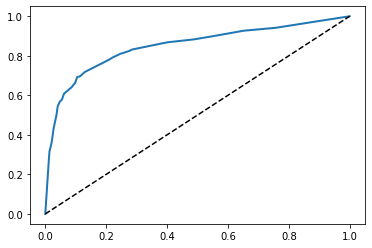

0.8486528657371482

In [573]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

y_scores = cross_val_predict(pipe_out, X_train, y_train, cv=3,
                             method="predict_proba")
                             #method="decision_function") #SGD
    
y_scores = y_scores[:, 1]   # score = proba of positive class

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()
# forest
# 0.856909225929727
# 0.8557619297938204 drop age

# knn
# 0.8406051048420068

# sgd
# n/a

roc_auc_score(y_train, y_scores)

## Submission

In [468]:
lin_class_test = LinearRegression()
svc_class_test = SVC(random_state=42)
forest_class_test = RandomForestClassifier(random_state=42)
knn_class_test = KNeighborsClassifier()
sgd_class_test = SGDClassifier(random_state=42, shuffle=True)

In [514]:
grid_search_test = GridSearchCV(knn_class_test, knn_param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, verbose=1)

#col_trans.named_transformers_["cat"].handle_unknown = 'ignore' # for dropping attributes

main_pipeline_test = Pipeline([
    ('col', col_trans),
    ('dropper', AttributesDropper()),
    ('grid', grid_search_test)
])

full_pipeline_test = GridSearchCV(main_pipeline_test, param_drpr, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=2)#, error_score='raise')

In [515]:
all_test_data = load_csv_as_pd("test.csv")
all_test_data_pp = preprocess_data(all_test_data)

X_train_all = all_train_data_pp.drop(target_label_col, axis=1)
y_train_all = all_train_data_pp[target_label_col].copy()

pipe_out_test = full_pipeline_test.fit(X_train_all, y_train_all)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.5s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..........................dropper__min_importance=0; total time=   1.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................dropper__min_importance=0.0002; total time=   1.7s
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................

In [516]:
print(full_pipeline_test.best_params_)
#print(full_pipeline_test.best_estimator_)
print(full_pipeline_test.best_estimator_.steps[2][1].best_params_)

#print(grid_search_test.named_steps['grid'].best_params_)
y_submission = pipe_out_test.predict(all_test_data_pp)
print(y_submission.shape)

df = pd.DataFrame(y_submission, columns=['Survived'])
df.insert(0, "PassengerId", all_test_data["PassengerId"], allow_duplicates=True)
df.to_csv("submission.csv", index=False)
df

{'dropper__min_importance': 0.0004}
{'n_neighbors': 10, 'weights': 'uniform'}
(418,)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


1. 0.75119: forest trained on subset of train.csv
2. 0.75598: forest trained on all data
3. 0.77751: knn .0001 drop?
4. 0.72966: sgd
5. 0.77751: knn .0003 drop
6. 0.77033: knn .00001 drop
7. 0.77751: knn .0004 drop